# Sentiment Classification the old-fashioned way: 
## `Naive Bayes`, `Logistic Regression`, and `Ngrams`

The purpose of this notebook is to show how sentiment classification is done via the classic techniques of `Naive Bayes`, `Logistic regression`, and `Ngrams`.  We will be using `sklearn` and the `fastai` library.

In a future lesson, we will revisit sentiment classification using `deep learning`, so that you can compare the two approaches.

The content here was extended from [Lesson 10 of the fast.ai Machine Learning course](https://course.fast.ai/lessonsml1/lesson10.html). Linear model is pretty close to the state of the art here.  Jeremy surpassed state of the art using a RNN in fall 2017.

## 0.The fastai library

We will begin using [the fastai library](https://docs.fast.ai) (version 1.0) in this notebook.  We will use it more once we move on to neural networks.

The fastai library is built on top of PyTorch and encodes many state-of-the-art best practices. It is used in production at a number of companies.  You can read more about it here:

- [Fast.ai's software could radically democratize AI](https://www.zdnet.com/article/fast-ais-new-software-could-radically-democratize-ai/) (ZDNet)

- [fastai v1 for PyTorch: Fast and accurate neural nets using modern best practices](https://www.fast.ai/2018/10/02/fastai-ai/) (fast.ai)

- [fastai docs](https://docs.fast.ai/)

### Installation

With conda:

`conda install -c pytorch -c fastai fastai=1.0`

Or with pip:

`pip install fastai==1.0`

More [installation information here](https://github.com/fastai/fastai/blob/master/README.md).

Beginning in lesson 4, we will be using GPUs, so if you want, you could switch to a [cloud option](https://course.fast.ai/#using-a-gpu) now to setup fastai.

In [7]:
import sys
print(sys.path)

['', '/anaconda3/lib/python36.zip', '/anaconda3/lib/python3.6', '/anaconda3/lib/python3.6/lib-dynload', '/anaconda3/lib/python3.6/site-packages', '/anaconda3/lib/python3.6/site-packages/aeosa', '/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/Ben/.ipython']


## 1. The IMDB dataset

<img src="IMDb.png" alt="floating point" style="width: 90%"/>

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB, We will use the version hosted as part [fast.ai datasets](https://course.fast.ai/datasets.html) on AWS Open Datasets. 

The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
#Looks like this bit has been phased out
from fastai.utils.mem import GPUMemTrace #call with mtrace

ModuleNotFoundError: No module named 'fastai.utils'

In [5]:
print (scipy.__version__)

NameError: name 'scipy' is not defined

In [3]:
import sklearn.feature_extraction.text as sklearn_text
import pickle 

### Preview the sample IMDb data set

fast.ai has a number of [datasets hosted via AWS Open Datasets](https://course.fast.ai/datasets.html) for easy download. We can see them by checking the docs for URLs (remember `??` is a helpful command):

In [5]:
?? URLs

Object `URLs` not found.


It is always good to start working on a sample of your data before you use the full dataset-- this allows for quicker computations as you debug and get your code working. For IMDB, there is a sample dataset already available:

In [7]:
#Did not work
#cd ~/.fastai/data/ 
#wget http://files.fast.ai/data/examples/imdb_sample.tgz

SyntaxError: invalid syntax (<ipython-input-7-54fde8b16c79>, line 1)

In [11]:
#Adding in this line to see if it gets untar_data function working - it does
from fastai.vision.all import *
path = untar_data(URLs.IMDB_SAMPLE)
path

Path('/Users/Ben/.fastai/data/imdb_sample')

#### Read the data set into a pandas dataframe, which we can inspect to get a sense of what our data looks like. We see that the three columns contain review label, review text, and the `is_valid` flag, respectively. `is_valid` is a boolean flag indicating whether the row is from the validation set or not.

In [12]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


### Extract the movie reviews from the sample IMDb data set.
#### We will be using [TextList](https://docs.fast.ai/text.data.html#TextList) from the fastai library:

TextList has got a training set, validation set and test set.

In [13]:
#This is not working right
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                         .label_from_df(cols=0))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 1
failure count is 2
failure count is 3
failure count is 4
failure count is 5
failure count is 6
failure count is 7
failure count is 8
failure count is 9
failure count is 10
failure count is 11
failure count is 12
failure count is 13
failure count is 14
failure count is 15
failure count is 16
failure count is 17
failure count is 18
failure count is 19
failure count is 20
failure count is 21
failure count is 22
failure count is 23
failure count is 24
failure count is 25
failure count is 26
failure count is 27
failure count is 28
failure count is 29
failure count is 30
failure count is 31
failure count is 32
failure count is 33
failure count is 34
failure count is 35
failure count is 36
failure count is 37
failure count is 38
failure count is 39
failure count is 40
failure count is 41
failure count is 42
failure count is 43
failure count is 44
failure count is 45
failure count is 46
failure count is 47
failure count is 48
failure count is 49
failure count is 50
failure c

failure count is 1355
failure count is 1356
failure count is 1357
failure count is 1358
failure count is 1359
failure count is 1360
failure count is 1361
failure count is 1362
failure count is 1363
failure count is 1364
failure count is 1365
failure count is 1366
failure count is 1367
failure count is 1368
failure count is 1369
failure count is 1370
failure count is 1371
failure count is 1372
failure count is 1373
failure count is 1374
failure count is 1375
failure count is 1376
failure count is 1377
failure count is 1378
failure count is 1379
failure count is 1380
failure count is 1381
failure count is 1382
failure count is 1383
failure count is 1384
failure count is 1385
failure count is 1386
failure count is 1387
failure count is 1388
failure count is 1389
failure count is 1390
failure count is 1391
failure count is 1392
failure count is 1393
failure count is 1394
failure count is 1395
failure count is 1396
failure count is 1397
failure count is 1398
failure count is 1399
failure co

failure count is 2825
failure count is 2826
failure count is 2827
failure count is 2828
failure count is 2829
failure count is 2830
failure count is 2831
failure count is 2832
failure count is 2833
failure count is 2834
failure count is 2835
failure count is 2836
failure count is 2837
failure count is 2838
failure count is 2839
failure count is 2840
failure count is 2841
failure count is 2842
failure count is 2843
failure count is 2844
failure count is 2845
failure count is 2846
failure count is 2847
failure count is 2848
failure count is 2849
failure count is 2850
failure count is 2851
failure count is 2852
failure count is 2853
failure count is 2854
failure count is 2855
failure count is 2856
failure count is 2857
failure count is 2858
failure count is 2859
failure count is 2860
failure count is 2861
failure count is 2862
failure count is 2863
failure count is 2864
failure count is 2865
failure count is 2866
failure count is 2867
failure count is 2868
failure count is 2869
failure co

failure count is 3892
failure count is 3893
failure count is 3894
failure count is 3895
failure count is 3896
failure count is 3897
failure count is 3898
failure count is 3899
failure count is 3900
failure count is 3901
failure count is 3902
failure count is 3903
failure count is 3904
failure count is 3905
failure count is 3906
failure count is 3907
failure count is 3908
failure count is 3909
failure count is 3910
failure count is 3911
failure count is 3912
failure count is 3913
failure count is 3914
failure count is 3915
failure count is 3916
failure count is 3917
failure count is 3918
failure count is 3919
failure count is 3920
failure count is 3921
failure count is 3922
failure count is 3923
failure count is 3924
failure count is 3925
failure count is 3926
failure count is 3927
failure count is 3928
failure count is 3929
failure count is 3930
failure count is 3931
failure count is 3932
failure count is 3933
failure count is 3934
failure count is 3935
failure count is 3936
failure co

failure count is 5295
failure count is 5296
failure count is 5297
failure count is 5298
failure count is 5299
failure count is 5300
failure count is 5301
failure count is 5302
failure count is 5303
failure count is 5304
failure count is 5305
failure count is 5306
failure count is 5307
failure count is 5308
failure count is 5309
failure count is 5310
failure count is 5311
failure count is 5312
failure count is 5313
failure count is 5314
failure count is 5315
failure count is 5316
failure count is 5317
failure count is 5318
failure count is 5319
failure count is 5320
failure count is 5321
failure count is 5322
failure count is 5323
failure count is 5324
failure count is 5325
failure count is 5326
failure count is 5327
failure count is 5328
failure count is 5329
failure count is 5330
failure count is 5331
failure count is 5332
failure count is 5333
failure count is 5334
failure count is 5335
failure count is 5336
failure count is 5337
failure count is 5338
failure count is 5339
failure co

failure count is 6167
failure count is 6168
failure count is 6169
failure count is 6170
failure count is 6171
failure count is 6172
failure count is 6173
failure count is 6174
failure count is 6175
failure count is 6176
failure count is 6177
failure count is 6178
failure count is 6179
failure count is 6180
failure count is 6181
failure count is 6182
failure count is 6183
failure count is 6184
failure count is 6185
failure count is 6186
failure count is 6187
failure count is 6188
failure count is 6189
failure count is 6190
failure count is 6191
failure count is 6192
failure count is 6193
failure count is 6194
failure count is 6195
failure count is 6196
failure count is 6197
failure count is 6198
failure count is 6199
failure count is 6200
failure count is 6201
failure count is 6202
failure count is 6203
failure count is 6204
failure count is 6205
failure count is 6206
failure count is 6207
failure count is 6208
failure count is 6209
failure count is 6210
failure count is 6211
failure co

failure count is 7364
failure count is 7365
failure count is 7366
failure count is 7367
failure count is 7368
failure count is 7369
failure count is 7370
failure count is 7371
failure count is 7372
failure count is 7373
failure count is 7374
failure count is 7375
failure count is 7376
failure count is 7377
failure count is 7378
failure count is 7379
failure count is 7380
failure count is 7381
failure count is 7382
failure count is 7383
failure count is 7384
failure count is 7385
failure count is 7386
failure count is 7387
failure count is 7388
failure count is 7389
failure count is 7390
failure count is 7391
failure count is 7392
failure count is 7393
failure count is 7394
failure count is 7395
failure count is 7396
failure count is 7397
failure count is 7398
failure count is 7399
failure count is 7400
failure count is 7401
failure count is 7402
failure count is 7403
failure count is 7404
failure count is 7405
failure count is 7406
failure count is 7407
failure count is 7408
failure co

failure count is 8685
failure count is 8686
failure count is 8687
failure count is 8688
failure count is 8689
failure count is 8690
failure count is 8691
failure count is 8692
failure count is 8693
failure count is 8694
failure count is 8695
failure count is 8696
failure count is 8697
failure count is 8698
failure count is 8699
failure count is 8700
failure count is 8701
failure count is 8702
failure count is 8703
failure count is 8704
failure count is 8705
failure count is 8706
failure count is 8707
failure count is 8708
failure count is 8709
failure count is 8710
failure count is 8711
failure count is 8712
failure count is 8713
failure count is 8714
failure count is 8715
failure count is 8716
failure count is 8717
failure count is 8718
failure count is 8719
failure count is 8720
failure count is 8721
failure count is 8722
failure count is 8723
failure count is 8724
failure count is 8725
failure count is 8726
failure count is 8727
failure count is 8728
failure count is 8729
failure co

failure count is 9648
failure count is 9649
failure count is 9650
failure count is 9651
failure count is 9652
failure count is 9653
failure count is 9654
failure count is 9655
failure count is 9656
failure count is 9657
failure count is 9658
failure count is 9659
failure count is 9660
failure count is 9661
failure count is 9662
failure count is 9663
failure count is 9664
failure count is 9665
failure count is 9666
failure count is 9667
failure count is 9668
failure count is 9669
failure count is 9670
failure count is 9671
failure count is 9672
failure count is 9673
failure count is 9674
failure count is 9675
failure count is 9676
failure count is 9677
failure count is 9678
failure count is 9679
failure count is 9680
failure count is 9681
failure count is 9682
failure count is 9683
failure count is 9684
failure count is 9685
failure count is 9686
failure count is 9687
failure count is 9688
failure count is 9689
failure count is 9690
failure count is 9691
failure count is 9692
failure co

failure count is 10773
failure count is 10774
failure count is 10775
failure count is 10776
failure count is 10777
failure count is 10778
failure count is 10779
failure count is 10780
failure count is 10781
failure count is 10782
failure count is 10783
failure count is 10784
failure count is 10785
failure count is 10786
failure count is 10787
failure count is 10788
failure count is 10789
failure count is 10790
failure count is 10791
failure count is 10792
failure count is 10793
failure count is 10794
failure count is 10795
failure count is 10796
failure count is 10797
failure count is 10798
failure count is 10799
failure count is 10800
failure count is 10801
failure count is 10802
failure count is 10803
failure count is 10804
failure count is 10805
failure count is 10806
failure count is 10807
failure count is 10808
failure count is 10809
failure count is 10810
failure count is 10811
failure count is 10812
failure count is 10813
failure count is 10814
failure count is 10815
failure cou

failure count is 11836
failure count is 11837
failure count is 11838
failure count is 11839
failure count is 11840
failure count is 11841
failure count is 11842
failure count is 11843
failure count is 11844
failure count is 11845
failure count is 11846
failure count is 11847
failure count is 11848
failure count is 11849
failure count is 11850
failure count is 11851
failure count is 11852
failure count is 11853
failure count is 11854
failure count is 11855
failure count is 11856
failure count is 11857
failure count is 11858
failure count is 11859
failure count is 11860
failure count is 11861
failure count is 11862
failure count is 11863
failure count is 11864
failure count is 11865
failure count is 11866
failure count is 11867
failure count is 11868
failure count is 11869
failure count is 11870
failure count is 11871
failure count is 11872
failure count is 11873
failure count is 11874
failure count is 11875
failure count is 11876
failure count is 11877
failure count is 11878
failure cou

failure count is 13288
failure count is 13289
failure count is 13290
failure count is 13291
failure count is 13292
failure count is 13293
failure count is 13294
failure count is 13295
failure count is 13296
failure count is 13297
failure count is 13298
failure count is 13299
failure count is 13300
failure count is 13301
failure count is 13302
failure count is 13303
failure count is 13304
failure count is 13305
failure count is 13306
failure count is 13307
failure count is 13308
failure count is 13309
failure count is 13310
failure count is 13311
failure count is 13312
failure count is 13313
failure count is 13314
failure count is 13315
failure count is 13316
failure count is 13317
failure count is 13318
failure count is 13319
failure count is 13320
failure count is 13321
failure count is 13322
failure count is 13323
failure count is 13324
failure count is 13325
failure count is 13326
failure count is 13327
failure count is 13328
failure count is 13329
failure count is 13330
failure cou

failure count is 14255
failure count is 14256
failure count is 14257
failure count is 14258
failure count is 14259
failure count is 14260
failure count is 14261
failure count is 14262
failure count is 14263
failure count is 14264
failure count is 14265
failure count is 14266
failure count is 14267
failure count is 14268
failure count is 14269
failure count is 14270
failure count is 14271
failure count is 14272
failure count is 14273
failure count is 14274
failure count is 14275
failure count is 14276
failure count is 14277
failure count is 14278
failure count is 14279
failure count is 14280
failure count is 14281
failure count is 14282
failure count is 14283
failure count is 14284
failure count is 14285
failure count is 14286
failure count is 14287
failure count is 14288
failure count is 14289
failure count is 14290
failure count is 14291
failure count is 14292
failure count is 14293
failure count is 14294
failure count is 14295
failure count is 14296
failure count is 14297
failure cou

failure count is 15323
failure count is 15324
failure count is 15325
failure count is 15326
failure count is 15327
failure count is 15328
failure count is 15329
failure count is 15330
failure count is 15331
failure count is 15332
failure count is 15333
failure count is 15334
failure count is 15335
failure count is 15336
failure count is 15337
failure count is 15338
failure count is 15339
failure count is 15340
failure count is 15341
failure count is 15342
failure count is 15343
failure count is 15344
failure count is 15345
failure count is 15346
failure count is 15347
failure count is 15348
failure count is 15349
failure count is 15350
failure count is 15351
failure count is 15352
failure count is 15353
failure count is 15354
failure count is 15355
failure count is 15356
failure count is 15357
failure count is 15358
failure count is 15359
failure count is 15360
failure count is 15361
failure count is 15362
failure count is 15363
failure count is 15364
failure count is 15365
failure cou

failure count is 16355
failure count is 16356
failure count is 16357
failure count is 16358
failure count is 16359
failure count is 16360
failure count is 16361
failure count is 16362
failure count is 16363
failure count is 16364
failure count is 16365
failure count is 16366
failure count is 16367
failure count is 16368
failure count is 16369
failure count is 16370
failure count is 16371
failure count is 16372
failure count is 16373
failure count is 16374
failure count is 16375
failure count is 16376
failure count is 16377
failure count is 16378
failure count is 16379
failure count is 16380
failure count is 16381
failure count is 16382
failure count is 16383
failure count is 16384
failure count is 16385
failure count is 16386
failure count is 16387
failure count is 16388
failure count is 16389
failure count is 16390
failure count is 16391
failure count is 16392
failure count is 16393
failure count is 16394
failure count is 16395
failure count is 16396
failure count is 16397
failure cou

failure count is 17748
failure count is 17749
failure count is 17750
failure count is 17751
failure count is 17752
failure count is 17753
failure count is 17754
failure count is 17755
failure count is 17756
failure count is 17757
failure count is 17758
failure count is 17759
failure count is 17760
failure count is 17761
failure count is 17762
failure count is 17763
failure count is 17764
failure count is 17765
failure count is 17766
failure count is 17767
failure count is 17768
failure count is 17769
failure count is 17770
failure count is 17771
failure count is 17772
failure count is 17773
failure count is 17774
failure count is 17775
failure count is 17776
failure count is 17777
failure count is 17778
failure count is 17779
failure count is 17780
failure count is 17781
failure count is 17782
failure count is 17783
failure count is 17784
failure count is 17785
failure count is 17786
failure count is 17787
failure count is 17788
failure count is 17789
failure count is 17790
failure cou

failure count is 18881
failure count is 18882
failure count is 18883
failure count is 18884
failure count is 18885
failure count is 18886
failure count is 18887
failure count is 18888
failure count is 18889
failure count is 18890
failure count is 18891
failure count is 18892
failure count is 18893
failure count is 18894
failure count is 18895
failure count is 18896
failure count is 18897
failure count is 18898
failure count is 18899
failure count is 18900
failure count is 18901
failure count is 18902
failure count is 18903
failure count is 18904
failure count is 18905
failure count is 18906
failure count is 18907
failure count is 18908
failure count is 18909
failure count is 18910
failure count is 18911
failure count is 18912
failure count is 18913
failure count is 18914
failure count is 18915
failure count is 18916
failure count is 18917
failure count is 18918
failure count is 18919
failure count is 18920
failure count is 18921
failure count is 18922
failure count is 18923
failure cou

failure count is 20334
failure count is 20335
failure count is 20336
failure count is 20337
failure count is 20338
failure count is 20339
failure count is 20340
failure count is 20341
failure count is 20342
failure count is 20343
failure count is 20344
failure count is 20345
failure count is 20346
failure count is 20347
failure count is 20348
failure count is 20349
failure count is 20350
failure count is 20351
failure count is 20352
failure count is 20353
failure count is 20354
failure count is 20355
failure count is 20356
failure count is 20357
failure count is 20358
failure count is 20359
failure count is 20360
failure count is 20361
failure count is 20362
failure count is 20363
failure count is 20364
failure count is 20365
failure count is 20366
failure count is 20367
failure count is 20368
failure count is 20369
failure count is 20370
failure count is 20371
failure count is 20372
failure count is 20373
failure count is 20374
failure count is 20375
failure count is 20376
failure cou

failure count is 21530
failure count is 21531
failure count is 21532
failure count is 21533
failure count is 21534
failure count is 21535
failure count is 21536
failure count is 21537
failure count is 21538
failure count is 21539
failure count is 21540
failure count is 21541
failure count is 21542
failure count is 21543
failure count is 21544
failure count is 21545
failure count is 21546
failure count is 21547
failure count is 21548
failure count is 21549
failure count is 21550
failure count is 21551
failure count is 21552
failure count is 21553
failure count is 21554
failure count is 21555
failure count is 21556
failure count is 21557
failure count is 21558
failure count is 21559
failure count is 21560
failure count is 21561
failure count is 21562
failure count is 21563
failure count is 21564
failure count is 21565
failure count is 21566
failure count is 21567
failure count is 21568
failure count is 21569
failure count is 21570
failure count is 21571
failure count is 21572
failure cou

failure count is 22762
failure count is 22763
failure count is 22764
failure count is 22765
failure count is 22766
failure count is 22767
failure count is 22768
failure count is 22769
failure count is 22770
failure count is 22771
failure count is 22772
failure count is 22773
failure count is 22774
failure count is 22775
failure count is 22776
failure count is 22777
failure count is 22778
failure count is 22779
failure count is 22780
failure count is 22781
failure count is 22782
failure count is 22783
failure count is 22784
failure count is 22785
failure count is 22786
failure count is 22787
failure count is 22788
failure count is 22789
failure count is 22790
failure count is 22791
failure count is 22792
failure count is 22793
failure count is 22794
failure count is 22795
failure count is 22796
failure count is 22797
failure count is 22798
failure count is 22799
failure count is 22800
failure count is 22801
failure count is 22802
failure count is 22803
failure count is 22804
failure cou

failure count is 23843
failure count is 23844
failure count is 23845
failure count is 23846
failure count is 23847
failure count is 23848
failure count is 23849
failure count is 23850
failure count is 23851
failure count is 23852
failure count is 23853
failure count is 23854
failure count is 23855
failure count is 23856
failure count is 23857
failure count is 23858
failure count is 23859
failure count is 23860
failure count is 23861
failure count is 23862
failure count is 23863
failure count is 23864
failure count is 23865
failure count is 23866
failure count is 23867
failure count is 23868
failure count is 23869
failure count is 23870
failure count is 23871
failure count is 23872
failure count is 23873
failure count is 23874
failure count is 23875
failure count is 23876
failure count is 23877
failure count is 23878
failure count is 23879
failure count is 23880
failure count is 23881
failure count is 23882
failure count is 23883
failure count is 23884
failure count is 23885
failure cou

failure count is 25176
failure count is 25177
failure count is 25178
failure count is 25179
failure count is 25180
failure count is 25181
failure count is 25182
failure count is 25183
failure count is 25184
failure count is 25185
failure count is 25186
failure count is 25187
failure count is 25188
failure count is 25189
failure count is 25190
failure count is 25191
failure count is 25192
failure count is 25193
failure count is 25194
failure count is 25195
failure count is 25196
failure count is 25197
failure count is 25198
failure count is 25199
failure count is 25200
failure count is 25201
failure count is 25202
failure count is 25203
failure count is 25204
failure count is 25205
failure count is 25206
failure count is 25207
failure count is 25208
failure count is 25209
failure count is 25210
failure count is 25211
failure count is 25212
failure count is 25213
failure count is 25214
failure count is 25215
failure count is 25216
failure count is 25217
failure count is 25218
failure cou

failure count is 26316
failure count is 26317
failure count is 26318
failure count is 26319
failure count is 26320
failure count is 26321
failure count is 26322
failure count is 26323
failure count is 26324
failure count is 26325
failure count is 26326
failure count is 26327
failure count is 26328
failure count is 26329
failure count is 26330
failure count is 26331
failure count is 26332
failure count is 26333
failure count is 26334
failure count is 26335
failure count is 26336
failure count is 26337
failure count is 26338
failure count is 26339
failure count is 26340
failure count is 26341
failure count is 26342
failure count is 26343
failure count is 26344
failure count is 26345
failure count is 26346
failure count is 26347
failure count is 26348
failure count is 26349
failure count is 26350
failure count is 26351
failure count is 26352
failure count is 26353
failure count is 26354
failure count is 26355
failure count is 26356
failure count is 26357
failure count is 26358
failure cou

failure count is 27838
failure count is 27839
failure count is 27840
failure count is 27841
failure count is 27842
failure count is 27843
failure count is 27844
failure count is 27845
failure count is 27846
failure count is 27847
failure count is 27848
failure count is 27849
failure count is 27850
failure count is 27851
failure count is 27852
failure count is 27853
failure count is 27854
failure count is 27855
failure count is 27856
failure count is 27857
failure count is 27858
failure count is 27859
failure count is 27860
failure count is 27861
failure count is 27862
failure count is 27863
failure count is 27864
failure count is 27865
failure count is 27866
failure count is 27867
failure count is 27868
failure count is 27869
failure count is 27870
failure count is 27871
failure count is 27872
failure count is 27873
failure count is 27874
failure count is 27875
failure count is 27876
failure count is 27877
failure count is 27878
failure count is 27879
failure count is 27880
failure cou

failure count is 29027
failure count is 29028
failure count is 29029
failure count is 29030
failure count is 29031
failure count is 29032
failure count is 29033
failure count is 29034
failure count is 29035
failure count is 29036
failure count is 29037
failure count is 29038
failure count is 29039
failure count is 29040
failure count is 29041
failure count is 29042
failure count is 29043
failure count is 29044
failure count is 29045
failure count is 29046
failure count is 29047
failure count is 29048
failure count is 29049
failure count is 29050
failure count is 29051
failure count is 29052
failure count is 29053
failure count is 29054
failure count is 29055
failure count is 29056
failure count is 29057
failure count is 29058
failure count is 29059
failure count is 29060
failure count is 29061
failure count is 29062
failure count is 29063
failure count is 29064
failure count is 29065
failure count is 29066
failure count is 29067
failure count is 29068
failure count is 29069
failure cou

failure count is 30342
failure count is 30343
failure count is 30344
failure count is 30345
failure count is 30346
failure count is 30347
failure count is 30348
failure count is 30349
failure count is 30350
failure count is 30351
failure count is 30352
failure count is 30353
failure count is 30354
failure count is 30355
failure count is 30356
failure count is 30357
failure count is 30358
failure count is 30359
failure count is 30360
failure count is 30361
failure count is 30362
failure count is 30363
failure count is 30364
failure count is 30365
failure count is 30366
failure count is 30367
failure count is 30368
failure count is 30369
failure count is 30370
failure count is 30371
failure count is 30372
failure count is 30373
failure count is 30374
failure count is 30375
failure count is 30376
failure count is 30377
failure count is 30378
failure count is 30379
failure count is 30380
failure count is 30381
failure count is 30382
failure count is 30383
failure count is 30384
failure cou

failure count is 31824
failure count is 31825
failure count is 31826
failure count is 31827
failure count is 31828
failure count is 31829
failure count is 31830
failure count is 31831
failure count is 31832
failure count is 31833
failure count is 31834
failure count is 31835
failure count is 31836
failure count is 31837
failure count is 31838
failure count is 31839
failure count is 31840
failure count is 31841
failure count is 31842
failure count is 31843
failure count is 31844
failure count is 31845
failure count is 31846
failure count is 31847
failure count is 31848
failure count is 31849
failure count is 31850
failure count is 31851
failure count is 31852
failure count is 31853
failure count is 31854
failure count is 31855
failure count is 31856
failure count is 31857
failure count is 31858
failure count is 31859
failure count is 31860
failure count is 31861
failure count is 31862
failure count is 31863
failure count is 31864
failure count is 31865
failure count is 31866
failure cou

failure count is 33090
failure count is 33091
failure count is 33092
failure count is 33093
failure count is 33094
failure count is 33095
failure count is 33096
failure count is 33097
failure count is 33098
failure count is 33099
failure count is 33100
failure count is 33101
failure count is 33102
failure count is 33103
failure count is 33104
failure count is 33105
failure count is 33106
failure count is 33107
failure count is 33108
failure count is 33109
failure count is 33110
failure count is 33111
failure count is 33112
failure count is 33113
failure count is 33114
failure count is 33115
failure count is 33116
failure count is 33117
failure count is 33118
failure count is 33119
failure count is 33120
failure count is 33121
failure count is 33122
failure count is 33123
failure count is 33124
failure count is 33125
failure count is 33126
failure count is 33127
failure count is 33128
failure count is 33129
failure count is 33130
failure count is 33131
failure count is 33132
failure cou

failure count is 34386
failure count is 34387
failure count is 34388
failure count is 34389
failure count is 34390
failure count is 34391
failure count is 34392
failure count is 34393
failure count is 34394
failure count is 34395
failure count is 34396
failure count is 34397
failure count is 34398
failure count is 34399
failure count is 34400
failure count is 34401
failure count is 34402
failure count is 34403
failure count is 34404
failure count is 34405
failure count is 34406
failure count is 34407
failure count is 34408
failure count is 34409
failure count is 34410
failure count is 34411
failure count is 34412
failure count is 34413
failure count is 34414
failure count is 34415
failure count is 34416
failure count is 34417
failure count is 34418
failure count is 34419
failure count is 34420
failure count is 34421
failure count is 34422
failure count is 34423
failure count is 34424
failure count is 34425
failure count is 34426
failure count is 34427
failure count is 34428
failure cou

failure count is 35865
failure count is 35866
failure count is 35867
failure count is 35868
failure count is 35869
failure count is 35870
failure count is 35871
failure count is 35872
failure count is 35873
failure count is 35874
failure count is 35875
failure count is 35876
failure count is 35877
failure count is 35878
failure count is 35879
failure count is 35880
failure count is 35881
failure count is 35882
failure count is 35883
failure count is 35884
failure count is 35885
failure count is 35886
failure count is 35887
failure count is 35888
failure count is 35889
failure count is 35890
failure count is 35891
failure count is 35892
failure count is 35893
failure count is 35894
failure count is 35895
failure count is 35896
failure count is 35897
failure count is 35898
failure count is 35899
failure count is 35900
failure count is 35901
failure count is 35902
failure count is 35903
failure count is 35904
failure count is 35905
failure count is 35906
failure count is 35907
failure cou

failure count is 37198
failure count is 37199
failure count is 37200
failure count is 37201
failure count is 37202
failure count is 37203
failure count is 37204
failure count is 37205
failure count is 37206
failure count is 37207
failure count is 37208
failure count is 37209
failure count is 37210
failure count is 37211
failure count is 37212
failure count is 37213
failure count is 37214
failure count is 37215
failure count is 37216
failure count is 37217
failure count is 37218
failure count is 37219
failure count is 37220
failure count is 37221
failure count is 37222
failure count is 37223
failure count is 37224
failure count is 37225
failure count is 37226
failure count is 37227
failure count is 37228
failure count is 37229
failure count is 37230
failure count is 37231
failure count is 37232
failure count is 37233
failure count is 37234
failure count is 37235
failure count is 37236
failure count is 37237
failure count is 37238
failure count is 37239
failure count is 37240
failure cou

failure count is 38101
failure count is 38102
failure count is 38103
failure count is 38104
failure count is 38105
failure count is 38106
failure count is 38107
failure count is 38108
failure count is 38109
failure count is 38110
failure count is 38111
failure count is 38112
failure count is 38113
failure count is 38114
failure count is 38115
failure count is 38116
failure count is 38117
failure count is 38118
failure count is 38119
failure count is 38120
failure count is 38121
failure count is 38122
failure count is 38123
failure count is 38124
failure count is 38125
failure count is 38126
failure count is 38127
failure count is 38128
failure count is 38129
failure count is 38130
failure count is 38131
failure count is 38132
failure count is 38133
failure count is 38134
failure count is 38135
failure count is 38136
failure count is 38137
failure count is 38138
failure count is 38139
failure count is 38140
failure count is 38141
failure count is 38142
failure count is 38143
failure cou

failure count is 39313
failure count is 39314
failure count is 39315
failure count is 39316
failure count is 39317
failure count is 39318
failure count is 39319
failure count is 39320
failure count is 39321
failure count is 39322
failure count is 39323
failure count is 39324
failure count is 39325
failure count is 39326
failure count is 39327
failure count is 39328
failure count is 39329
failure count is 39330
failure count is 39331
failure count is 39332
failure count is 39333
failure count is 39334
failure count is 39335
failure count is 39336
failure count is 39337
failure count is 39338
failure count is 39339
failure count is 39340
failure count is 39341
failure count is 39342
failure count is 39343
failure count is 39344
failure count is 39345
failure count is 39346
failure count is 39347
failure count is 39348
failure count is 39349
failure count is 39350
failure count is 39351
failure count is 39352
failure count is 39353
failure count is 39354
failure count is 39355
failure cou

failure count is 40713
failure count is 40714
failure count is 40715
failure count is 40716
failure count is 40717
failure count is 40718
failure count is 40719
failure count is 40720
failure count is 40721
failure count is 40722
failure count is 40723
failure count is 40724
failure count is 40725
failure count is 40726
failure count is 40727
failure count is 40728
failure count is 40729
failure count is 40730
failure count is 40731
failure count is 40732
failure count is 40733
failure count is 40734
failure count is 40735
failure count is 40736
failure count is 40737
failure count is 40738
failure count is 40739
failure count is 40740
failure count is 40741
failure count is 40742
failure count is 40743
failure count is 40744
failure count is 40745
failure count is 40746
failure count is 40747
failure count is 40748
failure count is 40749
failure count is 40750
failure count is 40751
failure count is 40752
failure count is 40753
failure count is 40754
failure count is 40755
failure cou

failure count is 41813
failure count is 41814
failure count is 41815
failure count is 41816
failure count is 41817
failure count is 41818
failure count is 41819
failure count is 41820
failure count is 41821
failure count is 41822
failure count is 41823
failure count is 41824
failure count is 41825
failure count is 41826
failure count is 41827
failure count is 41828
failure count is 41829
failure count is 41830
failure count is 41831
failure count is 41832
failure count is 41833
failure count is 41834
failure count is 41835
failure count is 41836
failure count is 41837
failure count is 41838
failure count is 41839
failure count is 41840
failure count is 41841
failure count is 41842
failure count is 41843
failure count is 41844
failure count is 41845
failure count is 41846
failure count is 41847
failure count is 41848
failure count is 41849
failure count is 41850
failure count is 41851
failure count is 41852
failure count is 41853
failure count is 41854
failure count is 41855
failure cou

failure count is 42879
failure count is 42880
failure count is 42881
failure count is 42882
failure count is 42883
failure count is 42884
failure count is 42885
failure count is 42886
failure count is 42887
failure count is 42888
failure count is 42889
failure count is 42890
failure count is 42891
failure count is 42892
failure count is 42893
failure count is 42894
failure count is 42895
failure count is 42896
failure count is 42897
failure count is 42898
failure count is 42899
failure count is 42900
failure count is 42901
failure count is 42902
failure count is 42903
failure count is 42904
failure count is 42905
failure count is 42906
failure count is 42907
failure count is 42908
failure count is 42909
failure count is 42910
failure count is 42911
failure count is 42912
failure count is 42913
failure count is 42914
failure count is 42915
failure count is 42916
failure count is 42917
failure count is 42918
failure count is 42919
failure count is 42920
failure count is 42921
failure cou

failure count is 44304
failure count is 44305
failure count is 44306
failure count is 44307
failure count is 44308
failure count is 44309
failure count is 44310
failure count is 44311
failure count is 44312
failure count is 44313
failure count is 44314
failure count is 44315
failure count is 44316
failure count is 44317
failure count is 44318
failure count is 44319
failure count is 44320
failure count is 44321
failure count is 44322
failure count is 44323
failure count is 44324
failure count is 44325
failure count is 44326
failure count is 44327
failure count is 44328
failure count is 44329
failure count is 44330
failure count is 44331
failure count is 44332
failure count is 44333
failure count is 44334
failure count is 44335
failure count is 44336
failure count is 44337
failure count is 44338
failure count is 44339
failure count is 44340
failure count is 44341
failure count is 44342
failure count is 44343
failure count is 44344
failure count is 44345
failure count is 44346
failure cou

failure count is 45218
failure count is 45219
failure count is 45220
failure count is 45221
failure count is 45222
failure count is 45223
failure count is 45224
failure count is 45225
failure count is 45226
failure count is 45227
failure count is 45228
failure count is 45229
failure count is 45230
failure count is 45231
failure count is 45232
failure count is 45233
failure count is 45234
failure count is 45235
failure count is 45236
failure count is 45237
failure count is 45238
failure count is 45239
failure count is 45240
failure count is 45241
failure count is 45242
failure count is 45243
failure count is 45244
failure count is 45245
failure count is 45246
failure count is 45247
failure count is 45248
failure count is 45249
failure count is 45250
failure count is 45251
failure count is 45252
failure count is 45253
failure count is 45254
failure count is 45255
failure count is 45256
failure count is 45257
failure count is 45258
failure count is 45259
failure count is 45260
failure cou

failure count is 46146
failure count is 46147
failure count is 46148
failure count is 46149
failure count is 46150
failure count is 46151
failure count is 46152
failure count is 46153
failure count is 46154
failure count is 46155
failure count is 46156
failure count is 46157
failure count is 46158
failure count is 46159
failure count is 46160
failure count is 46161
failure count is 46162
failure count is 46163
failure count is 46164
failure count is 46165
failure count is 46166
failure count is 46167
failure count is 46168
failure count is 46169
failure count is 46170
failure count is 46171
failure count is 46172
failure count is 46173
failure count is 46174
failure count is 46175
failure count is 46176
failure count is 46177
failure count is 46178
failure count is 46179
failure count is 46180
failure count is 46181
failure count is 46182
failure count is 46183
failure count is 46184
failure count is 46185
failure count is 46186
failure count is 46187
failure count is 46188
failure cou

failure count is 47377
failure count is 47378
failure count is 47379
failure count is 47380
failure count is 47381
failure count is 47382
failure count is 47383
failure count is 47384
failure count is 47385
failure count is 47386
failure count is 47387
failure count is 47388
failure count is 47389
failure count is 47390
failure count is 47391
failure count is 47392
failure count is 47393
failure count is 47394
failure count is 47395
failure count is 47396
failure count is 47397
failure count is 47398
failure count is 47399
failure count is 47400
failure count is 47401
failure count is 47402
failure count is 47403
failure count is 47404
failure count is 47405
failure count is 47406
failure count is 47407
failure count is 47408
failure count is 47409
failure count is 47410
failure count is 47411
failure count is 47412
failure count is 47413
failure count is 47414
failure count is 47415
failure count is 47416
failure count is 47417
failure count is 47418
failure count is 47419
failure cou

failure count is 48820
failure count is 48821
failure count is 48822
failure count is 48823
failure count is 48824
failure count is 48825
failure count is 48826
failure count is 48827
failure count is 48828
failure count is 48829
failure count is 48830
failure count is 48831
failure count is 48832
failure count is 48833
failure count is 48834
failure count is 48835
failure count is 48836
failure count is 48837
failure count is 48838
failure count is 48839
failure count is 48840
failure count is 48841
failure count is 48842
failure count is 48843
failure count is 48844
failure count is 48845
failure count is 48846
failure count is 48847
failure count is 48848
failure count is 48849
failure count is 48850
failure count is 48851
failure count is 48852
failure count is 48853
failure count is 48854
failure count is 48855
failure count is 48856
failure count is 48857
failure count is 48858
failure count is 48859
failure count is 48860
failure count is 48861
failure count is 48862
failure cou

failure count is 49882
failure count is 49883
failure count is 49884
failure count is 49885
failure count is 49886
failure count is 49887
failure count is 49888
failure count is 49889
failure count is 49890
failure count is 49891
failure count is 49892
failure count is 49893
failure count is 49894
failure count is 49895
failure count is 49896
failure count is 49897
failure count is 49898
failure count is 49899
failure count is 49900
failure count is 49901
failure count is 49902
failure count is 49903
failure count is 49904
failure count is 49905
failure count is 49906
failure count is 49907
failure count is 49908
failure count is 49909
failure count is 49910
failure count is 49911
failure count is 49912
failure count is 49913
failure count is 49914
failure count is 49915
failure count is 49916
failure count is 49917
failure count is 49918
failure count is 49919
failure count is 49920
failure count is 49921
failure count is 49922
failure count is 49923
failure count is 49924
failure cou

failure count is 51193
failure count is 51194
failure count is 51195
failure count is 51196
failure count is 51197
failure count is 51198
failure count is 51199
failure count is 51200
failure count is 51201
failure count is 51202
failure count is 51203
failure count is 51204
failure count is 51205
failure count is 51206
failure count is 51207
failure count is 51208
failure count is 51209
failure count is 51210
failure count is 51211
failure count is 51212
failure count is 51213
failure count is 51214
failure count is 51215
failure count is 51216
failure count is 51217
failure count is 51218
failure count is 51219
failure count is 51220
failure count is 51221
failure count is 51222
failure count is 51223
failure count is 51224
failure count is 51225
failure count is 51226
failure count is 51227
failure count is 51228
failure count is 51229
failure count is 51230
failure count is 51231
failure count is 51232
failure count is 51233
failure count is 51234
failure count is 51235
failure cou

failure count is 52352
failure count is 52353
failure count is 52354
failure count is 52355
failure count is 52356
failure count is 52357
failure count is 52358
failure count is 52359
failure count is 52360
failure count is 52361
failure count is 52362
failure count is 52363
failure count is 52364
failure count is 52365
failure count is 52366
failure count is 52367
failure count is 52368
failure count is 52369
failure count is 52370
failure count is 52371
failure count is 52372
failure count is 52373
failure count is 52374
failure count is 52375
failure count is 52376
failure count is 52377
failure count is 52378
failure count is 52379
failure count is 52380
failure count is 52381
failure count is 52382
failure count is 52383
failure count is 52384
failure count is 52385
failure count is 52386
failure count is 52387
failure count is 52388
failure count is 52389
failure count is 52390
failure count is 52391
failure count is 52392
failure count is 52393
failure count is 52394
failure cou

failure count is 53815
failure count is 53816
failure count is 53817
failure count is 53818
failure count is 53819
failure count is 53820
failure count is 53821
failure count is 53822
failure count is 53823
failure count is 53824
failure count is 53825
failure count is 53826
failure count is 53827
failure count is 53828
failure count is 53829
failure count is 53830
failure count is 53831
failure count is 53832
failure count is 53833
failure count is 53834
failure count is 53835
failure count is 53836
failure count is 53837
failure count is 53838
failure count is 53839
failure count is 53840
failure count is 53841
failure count is 53842
failure count is 53843
failure count is 53844
failure count is 53845
failure count is 53846
failure count is 53847
failure count is 53848
failure count is 53849
failure count is 53850
failure count is 53851
failure count is 53852
failure count is 53853
failure count is 53854
failure count is 53855
failure count is 53856
failure count is 53857
failure cou

failure count is 54937
failure count is 54938
failure count is 54939
failure count is 54940
failure count is 54941
failure count is 54942
failure count is 54943
failure count is 54944
failure count is 54945
failure count is 54946
failure count is 54947
failure count is 54948
failure count is 54949
failure count is 54950
failure count is 54951
failure count is 54952
failure count is 54953
failure count is 54954
failure count is 54955
failure count is 54956
failure count is 54957
failure count is 54958
failure count is 54959
failure count is 54960
failure count is 54961
failure count is 54962
failure count is 54963
failure count is 54964
failure count is 54965
failure count is 54966
failure count is 54967
failure count is 54968
failure count is 54969
failure count is 54970
failure count is 54971
failure count is 54972
failure count is 54973
failure count is 54974
failure count is 54975
failure count is 54976
failure count is 54977
failure count is 54978
failure count is 54979
failure cou

failure count is 56302
failure count is 56303
failure count is 56304
failure count is 56305
failure count is 56306
failure count is 56307
failure count is 56308
failure count is 56309
failure count is 56310
failure count is 56311
failure count is 56312
failure count is 56313
failure count is 56314
failure count is 56315
failure count is 56316
failure count is 56317
failure count is 56318
failure count is 56319
failure count is 56320
failure count is 56321
failure count is 56322
failure count is 56323
failure count is 56324
failure count is 56325
failure count is 56326
failure count is 56327
failure count is 56328
failure count is 56329
failure count is 56330
failure count is 56331
failure count is 56332
failure count is 56333
failure count is 56334
failure count is 56335
failure count is 56336
failure count is 56337
failure count is 56338
failure count is 56339
failure count is 56340
failure count is 56341
failure count is 56342
failure count is 56343
failure count is 56344
failure cou

failure count is 57306
failure count is 57307
failure count is 57308
failure count is 57309
failure count is 57310
failure count is 57311
failure count is 57312
failure count is 57313
failure count is 57314
failure count is 57315
failure count is 57316
failure count is 57317
failure count is 57318
failure count is 57319
failure count is 57320
failure count is 57321
failure count is 57322
failure count is 57323
failure count is 57324
failure count is 57325
failure count is 57326
failure count is 57327
failure count is 57328
failure count is 57329
failure count is 57330
failure count is 57331
failure count is 57332
failure count is 57333
failure count is 57334
failure count is 57335
failure count is 57336
failure count is 57337
failure count is 57338
failure count is 57339
failure count is 57340
failure count is 57341
failure count is 57342
failure count is 57343
failure count is 57344
failure count is 57345
failure count is 57346
failure count is 57347
failure count is 57348
failure cou

failure count is 58339
failure count is 58340
failure count is 58341
failure count is 58342
failure count is 58343
failure count is 58344
failure count is 58345
failure count is 58346
failure count is 58347
failure count is 58348
failure count is 58349
failure count is 58350
failure count is 58351
failure count is 58352
failure count is 58353
failure count is 58354
failure count is 58355
failure count is 58356
failure count is 58357
failure count is 58358
failure count is 58359
failure count is 58360
failure count is 58361
failure count is 58362
failure count is 58363
failure count is 58364
failure count is 58365
failure count is 58366
failure count is 58367
failure count is 58368
failure count is 58369
failure count is 58370
failure count is 58371
failure count is 58372
failure count is 58373
failure count is 58374
failure count is 58375
failure count is 58376
failure count is 58377
failure count is 58378
failure count is 58379
failure count is 58380
failure count is 58381
failure cou

failure count is 59766
failure count is 59767
failure count is 59768
failure count is 59769
failure count is 59770
failure count is 59771
failure count is 59772
failure count is 59773
failure count is 59774
failure count is 59775
failure count is 59776
failure count is 59777
failure count is 59778
failure count is 59779
failure count is 59780
failure count is 59781
failure count is 59782
failure count is 59783
failure count is 59784
failure count is 59785
failure count is 59786
failure count is 59787
failure count is 59788
failure count is 59789
failure count is 59790
failure count is 59791
failure count is 59792
failure count is 59793
failure count is 59794
failure count is 59795
failure count is 59796
failure count is 59797
failure count is 59798
failure count is 59799
failure count is 59800
failure count is 59801
failure count is 59802
failure count is 59803
failure count is 59804
failure count is 59805
failure count is 59806
failure count is 59807
failure count is 59808
failure cou

failure count is 60551
failure count is 60552
failure count is 60553
failure count is 60554
failure count is 60555
failure count is 60556
failure count is 60557
failure count is 60558
failure count is 60559
failure count is 60560
failure count is 60561
failure count is 60562
failure count is 60563
failure count is 60564
failure count is 60565
failure count is 60566
failure count is 60567
failure count is 60568
failure count is 60569
failure count is 60570
failure count is 60571
failure count is 60572
failure count is 60573
failure count is 60574
failure count is 60575
failure count is 60576
failure count is 60577
failure count is 60578
failure count is 60579
failure count is 60580
failure count is 60581
failure count is 60582
failure count is 60583
failure count is 60584
failure count is 60585
failure count is 60586
failure count is 60587
failure count is 60588
failure count is 60589
failure count is 60590
failure count is 60591
failure count is 60592
failure count is 60593
failure cou

KeyboardInterrupt: 

### Exploring IMDb review data

A good first step for any data problem is to explore the data and get a sense of what it looks like.  In this case we are looking at movie reviews, which have been labeled as "positive" or "negative". The reviews have already been `tokenized`, i.e. split into `tokens`, basic units such as words, prefixes, punctuation, capitalization, and other features of the text.

xxunk - word that is unknown, xxbos - beginning of string, xxmaj - capital letter, 

In [14]:
movie_reviews

NameError: name 'movie_reviews' is not defined

### Let's examine the`movie_reviews` object:

In [9]:
dir(movie_reviews)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_test',
 'add_test_folder',
 'databunch',
 'filter_by_func',
 'get_processors',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_list',
 'label_from_lists',
 'label_from_re',
 'lists',
 'load_empty',
 'load_state',
 'path',
 'process',
 'test',
 'train',
 'transform',
 'transform_y',
 'valid']

### `movie_reviews` splits the data into training and validation sets, `.train` and `.valid` 

In [10]:
print(f'There are {len(movie_reviews.train.x)} and {len(movie_reviews.valid.x)} reviews in the training and validations sets, respectively.')

There are 800 and 200 reviews in the training and validations sets, respectively.


### Reviews are composed of lists of tokens. In NLP, a **token** is the basic unit of processing (what the tokens are depends on the application and your choices). Here, the tokens mostly correspond to words or punctuation, as well as several special tokens, corresponding to unknown words, capitalization, etc.

### Special tokens:
All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 

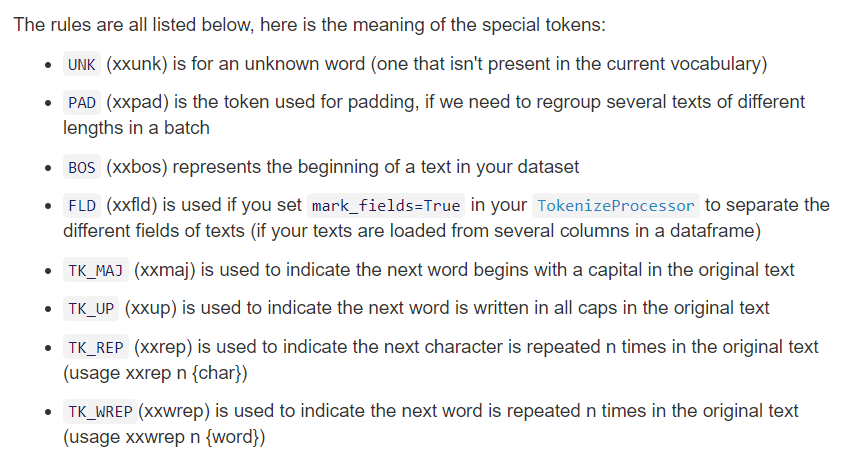

### Let's examine the structure of the `training set`

#### movie_reviews.train is a `LabelList` object. 
#### movie_reviews.train.x  is a `TextList` object that holds the reviews
#### movie_reviews.train.y is a `CategoryList` object that holds the labels 

In [11]:
print(f'\fThere are {len(movie_reviews.train.x)} movie reviews in the training set\n')
print(movie_reviews.train)

There are 800 movie reviews in the training set

LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard

#### The text of the movie review is stored as a character `string`, which contains the tokens separated by spaces. Here is the text of the first review:

In [12]:
print(movie_reviews.train.x[0].text)
print(f'\nThere are {len(movie_reviews.train.x[0].text)} characters in the review')

xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

There are 511 characters in the review


#### The text string can be split to get the list of tokens.

In [13]:
print(movie_reviews.train.x[0].text.split())
print(f'\nThe review has {len(movie_reviews.train.x[0].text.split())} tokens')

['xxbos', 'xxmaj', 'un', '-', 'xxunk', '-', 'believable', '!', 'xxmaj', 'meg', 'xxmaj', 'ryan', 'does', "n't", 'even', 'look', 'her', 'usual', 'xxunk', 'lovable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'xxunk', 'acting', 'xxunk', '.', 'xxmaj', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'xxmaj', 'plus', 'xxmaj', 'kevin', 'xxmaj', 'kline', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'xxmaj', 'xxunk', '...', 'xxmaj', 'xxunk', '!', '!', '!', 'xxmaj', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'xxmaj', 'big', 'xxmaj', 'xxunk', '?', 'xxmaj', 'must', 'be', 'a', 'replay', 'of', 'xxmaj', 'jonestown', '-', 'hollywood', 'style', '.', 'xxmaj', 'xxunk', '!']

The review has 103 tokens


#### The review tokens are `numericalized`, ie. mapped to integers.  So a movie review is also stored as an array of integers:

In [14]:
print(movie_reviews.train.x[0].data)
print(f'\nThe array contains {len(movie_reviews.train.x[0].data)} numericalized tokens')

[   2    5 4622   25 ...   10    5    0   52]

The array contains 103 numericalized tokens


## 2. The IMDb Vocabulary

### The `movie_revews` object also contains a `.vocab` property, even though it is not shown with`dir()`. (This may be an error in the `fastai` library.) 

In [15]:
movie_reviews.vocab

### The `vocab` object is a kind of reversible dictionary that translates back and forth between tokens and their integer representations.  It has two methods of particular interest: `stoi` and `itos`, which stand for `string-to-index` and `index-to-string`

#### `movie_reviews.vocab.stoi` maps vocabulary tokens to their `indexes` in vocab

In [16]:
movie_reviews.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             'the': 9,
             '.': 10,
             ',': 11,
             'and': 12,
             'a': 13,
             'of': 14,
             'to': 15,
             'is': 16,
             'it': 17,
             'in': 18,
             'i': 19,
             'that': 20,
             'this': 21,
             '"': 22,
             "'s": 23,
             '\n \n ': 24,
             '-': 25,
             'was': 26,
             'as': 27,
             'for': 28,
             'movie': 29,
             'with': 30,
             'but': 31,
             'film': 32,
             'you': 33,
             ')': 34,
             'on': 35,
             '(': 36,
             "n't": 37,
             'are': 38,
             'he': 39,
             'his': 40,
       

#### `movie_reviews.vocab.itos` maps the `indexes` of vocabulary tokens to `strings`

In [17]:
movie_reviews.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'that',
 'this',
 '"',
 "'s",
 '\n \n ',
 '-',
 'was',
 'as',
 'for',
 'movie',
 'with',
 'but',
 'film',
 'you',
 ')',
 'on',
 '(',
 "n't",
 'are',
 'he',
 'his',
 'not',
 'have',
 'be',
 'one',
 'they',
 'all',
 'at',
 'by',
 'an',
 'from',
 'like',
 '!',
 'so',
 'who',
 'there',
 'about',
 'just',
 'out',
 'if',
 'or',
 'do',
 'what',
 'her',
 'has',
 "'",
 'some',
 'more',
 'good',
 'when',
 'up',
 'very',
 '?',
 'she',
 'would',
 'no',
 'really',
 'were',
 'their',
 'my',
 'had',
 'time',
 'can',
 'only',
 'which',
 'even',
 'see',
 'story',
 'me',
 'into',
 'did',
 ':',
 'well',
 'we',
 'will',
 'does',
 'than',
 'also',
 'get',
 '...',
 'people',
 'other',
 'bad',
 'been',
 'could',
 'first',
 'much',
 'how',
 'most',
 'any',
 'because',
 'two',
 'then',
 'great',
 'him',
 'its',
 'too',
 'made',
 'them',
 'after',


#### Notice that ints-to-string and string-to-ints have different lengths.  Think for a moment about why this is.
See Hint below

In [18]:
print('itos ', 'length ',len(movie_reviews.vocab.itos),type(movie_reviews.vocab.itos) )
print('stoi ', 'length ',len(movie_reviews.vocab.stoi),type(movie_reviews.vocab.stoi) )

itos  length  6016 <class 'list'>
stoi  length  19160 <class 'collections.defaultdict'>


#### Hint: `stoi` is an instance of the class `defaultdict`
<img src="default_dict.png" alt="floating point" style="width: 90%"/>

#### In a `defaultdict`, rare words that appear fewer than three times in the corpus, and words that are not in the dictionary, are mapped to a `default value`, in this case, zero

In [19]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(movie_reviews.vocab.stoi[word])

0
0
0
0
0
0


#### What's the `token` corresponding to the `default` value?

In [20]:
print(movie_reviews.vocab.itos[0])

xxunk


#### Note that `stoi` (string-to-int) is larger than `itos` (int-to-string).

In [21]:
print(f'len(stoi) = {len(movie_reviews.vocab.stoi)}')
print(f'len(itos) = {len(movie_reviews.vocab.itos)}')
print(f'len(stoi) - len(itos) = {len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos)}')

len(stoi) = 19165
len(itos) = 6016
len(stoi) - len(itos) = 13149


#### This is because many words map to `unknown`.  We can confirm here:

In [22]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)

In [23]:
len(unk)

13155

#### Question: why isn't len(unk) = len(stoi) - len(itos)?
Hint: remember the list of rare words we used to query `stoi` a few cells back?

#### Here are the first 25 words that are mapped to `unknown`

In [24]:
unk[:25]

['xxunk',
 'bleeping',
 'pert',
 'ticky',
 'schtick',
 'whoosh',
 'banzai',
 'chill',
 'wooofff',
 'cheery',
 'superstars',
 'fashionable',
 'cruelly',
 'separating',
 'mistreat',
 'tensions',
 'religions',
 'baseness',
 'nobility',
 'puro',
 'disowned',
 'option',
 'faults',
 'dignified',
 'realisation']

## 3. Map the movie reviews into a vector space

### There are 6016 unique tokens in the IMDb review vocabulary. Their numericalized values range from 0 to 6015

In [25]:
print(f'There are {len(movie_reviews.vocab.itos)} unique tokens in the IMDb review sample vocabulary')
print(f'The numericalized token values run from {min(movie_reviews.vocab.stoi.values())} to {max(movie_reviews.vocab.stoi.values())} ')

There are 6016 unique tokens in the IMDb review sample vocabulary
The numericalized token values run from 0 to 6015 


### Each review can be mapped to a 6016-dimensional `embedding vector` whose indices correspond to the numericalized tokens, and whose values are the number of times the corresponding token appeared in the review. To do this efficiently we need to learn a bit about `Counters`.

### 3A. Counters

A **Counter** is a useful Python object.  A **Counter** applied to a list returns an ordered dictionary whose keys are the unique elements in the list, and whose values are the counts of the unique elements. Counters are from the collections module (along with OrderedDict, defaultdict, deque, and namedtuple).
Here is how Counters work:

#### Let's make a TokenCounter for movie reviews

In [26]:
TokenCounter = lambda review_index : Counter((movie_reviews.train.x)[review_index].data)
TokenCounter(0).items()

dict_items([(2, 1), (5, 15), (4622, 1), (25, 3), (0, 8), (867, 1), (52, 5), (3776, 1), (1800, 1), (95, 1), (37, 1), (85, 1), (191, 1), (63, 2), (936, 1), (2740, 1), (517, 1), (18, 1), (21, 3), (11, 1), (84, 1), (2418, 1), (192, 1), (88, 1), (3777, 1), (1801, 1), (127, 1), (10, 3), (269, 1), (15, 1), (273, 1), (73, 1), (26, 2), (9, 2), (1360, 1), (35, 2), (1213, 1), (1144, 1), (1145, 1), (2419, 1), (91, 1), (62, 1), (245, 1), (14, 2), (1361, 1), (1447, 1), (64, 1), (40, 1), (797, 1), (103, 1), (72, 2), (99, 1), (534, 1), (616, 1), (48, 1), (282, 1), (54, 1), (90, 1), (219, 1), (228, 1), (43, 1), (13, 1), (3778, 1), (3779, 1), (355, 1), (492, 1)])

#### The TokenCounter `keys` are the numericalized `tokens` that apper in the review

In [27]:
TokenCounter(0).keys()

dict_keys([2, 5, 4622, 25, 0, 867, 52, 3776, 1800, 95, 37, 85, 191, 63, 936, 2740, 517, 18, 21, 11, 84, 2418, 192, 88, 3777, 1801, 127, 10, 269, 15, 273, 73, 26, 9, 1360, 35, 1213, 1144, 1145, 2419, 91, 62, 245, 14, 1361, 1447, 64, 40, 797, 103, 72, 99, 534, 616, 48, 282, 54, 90, 219, 228, 43, 13, 3778, 3779, 355, 492])

#### The TokenCounter `values` are the `token multiplicities`, i.e the number of times each `token` appears in the review

In [28]:
TokenCounter(0).values()

dict_values([1, 15, 1, 3, 8, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 3B. Mapping movie reviews to `embedding vectors`

#### Make a `count_vectorizer` function that represents a movie review as a 6016-dimensional `embedding vector`
#### The `indices` of  the `embedding vector` correspond to the n6016 numericalized tokens in the vocabulary; the `values` specify how often the corresponding token appears in the review. 

In [29]:
n_terms = len(movie_reviews.vocab.itos)
n_docs = len(movie_reviews.train.x)
make_token_counter = lambda review_index: Counter(movie_reviews.train.x[review_index].data)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = make_token_counter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# make the embedding vector for the first review
embedding_vector = count_vectorizer(0)

#### Here is the `embedding vector` for the first review in the training data set

In [30]:
print(f'The review is embedded in a {len(embedding_vector)} dimensional vector')
embedding_vector

The review is embedded in a 6016 dimensional vector


array([8., 0., 1., 0., ..., 0., 0., 0., 0.])

## 4. Create the document-term matrix for the IMDb

#### In non-deep learning methods of NLP, we are often interested only in `which words` were used in a review, and `how often each word got used`. This is known as the `bag of words` approach, and it suggests a really simple way to store a document (in this case, a movie review). 

#### For each review we can keep track of which words were used and how often each word was used with a `vector` whose `length` is the number of tokens in the vocabulary, which we will call `n`. The `indexes` of this `vector` correspond to the `tokens` in the `IMDb vocabulary`, and the`values` of the vector are the number of times the corresponding tokens appeared in the review. For example the values stored at indexes 0, 1, 2, 3, 4 of the vector record the number of times the 5 tokens ['xxunk','xxpad','xxbos','xxeos','xxfld'] appeared in the review, respectively.

#### Now, if our movie review database has `m` reviews, and each review is represented by a `vector` of length `n`, then vertically stacking the row vectors for all the reviews creates a matrix representation of the IMDb, which we call its `document-term matrix`. The `rows` correspond to `documents` (reviews), while the `columns` correspond to `terms` (or tokens in the vocabulary).

In the previous lesson, we used [sklearn's CountVectorizer](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L940) to generate the `vectors` that represent individual reviews. Today we will create our own (similar) version.  This is for two reasons:
- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

### Form the embedding vectors for the movie_reviews in the training set and stack them vertically

In [31]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_terms} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_terms,n_docs=n_docs):
    
    # loop through the movie reviews
    for doc_index in range(n_docs):
        
        # make the embedding vector for the current review
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer)

there are 800 reviews, and 6016 unique tokens in the vocabulary


### Explore the `sparsity` of the document-term matrix

#### The `sparsity` of a matrix is defined as the fraction of of zero-valued elements

In [32]:
NNZ = np.count_nonzero(A)
sparsity = (A.size-NNZ)/A.size
print(f'Only {NNZ} of the {A.size} elements in the document-term matrix are nonzero')
print(f'The sparsity of the document-term matrix is {sparsity}')

Only 112413 of the 4812800 elements in the document-term matrix are nonzero
The sparsity of the document-term matrix is 0.9766429105718085


#### Using matplotlib's `spy` method, we can visualize the structure of the `document-term matrix`
`spy` plots the array, indicating each non-zero value with a dot.

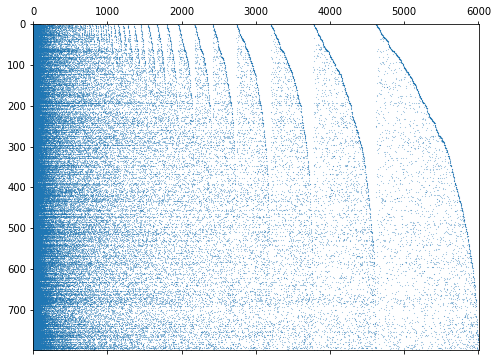

In [33]:
fig = plt.figure()
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)
fig.savefig('doc_term_matrix.png', dpi=800)

#### Several observations stand out:
1. Evidently, the document-term matrix is `sparse` ie. has a high proportion of zeros! 
2. The density of the matrix increases toward the `left` edge. This makes sense because the tokens are ordered by usage frequency, with frequency increasing toward the `left`.
3. There is a perplexing pattern of curved vertical `density ripples`. If anyone has an explanation, please let me know! 

#### Next we'll see how to  exploit matrix sparsity to save memory storage space, and compute time and resources.


## 5. Sparse Matrix Representation

#### Even though we've reduced over 19,000 unique words in our corpus of reviews down to a vocabulary of 6,000 words, that's still a lot! But reviews are generally short, a few hundred words. So most tokens don't appear in a typical review.  That means that most of the entries in the document-term matrix will be zeros, and therefore ordinary matrix operations will waste a lot of compute resources multiplying and adding zeros. 

####  We want to maximize the use of space and time by storing and performing matrix operations on our document-term matrix as a **sparse matrix**. `scipy` provides tools for efficient sparse matrix representatin and operations. 

#### Loosely speaking,  matrix with a high proportion of zeros is called `sparse` (the opposite of sparse is `dense`).  For sparse matrices, you can save a lot of memory by only storing the non-zero values.

#### More specifically, a class of matrices is called **sparse** if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns. An example is the class of diagonal matrices.


<img src="images/sparse.png" alt="floating point" style="width: 30%"/>



### Visualizing sparse matrix structure
<img src="sparse-matrix-structure-visualization.png" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/introduction.html

### Sparse matrix storage formats

<img src="summary_of_sparse_matrix_storage_schemes.png" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html

There are the most common sparse storage formats:
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)



### Definition of the Compressed Sparse Row (CSR) format

Let's start out with a presecription for the **CSR format** (ref. https://en.wikipedia.org/wiki/Sparse_matrix)

Given a full matrix **`A`** that has **`m`** rows, **`n`** columns, and **`N`** nonzero values, the CSR (Compressed Sparse Row) representation uses three arrays as follows:

1. **`Val[0:N]`** contains the **values** of the **`N` non-zero elements**.

2. **`Col[0:N]`** contains the **column indices** of the **`N` non-zero elements**. 
    
3. For each row **`i`** of **`A`**, **`RowPointer[i]`** contains the index in **Val** of the the first **nonzero value** in row **`i`**. If there are no nonzero values in the **ith** row, then **`RowPointer[i] = None`**. And, by convention, an extra value **`RowPointer[m] = N`** is tacked on at the end. 

Question: How many floats and ints does it take to store the matrix **`A`** in CSR format?

Let's walk through [a few examples](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html) at the Emory University website



## 6. Store the document-term matrix in CSR format
i.e. given the `TextList` object containing the list of reviews, return the three arrays (values, column_indices, row_pointer)

### Scipy Implementation of sparse matrices

From the [Scipy Sparse Matrix Documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. As illustrated below, the COO format may also be used to efficiently construct matrices
- To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format.
- All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.

### To really understand the CSR format, we need to be able know how to do two things:
1. Translate a regular matrix A into CSR format
2. Reconstruct a regular matrix from its CSR sparse representation


### 6.1. Translate a regular matrix A into CSR format
This is done by implementing the definition of `CSR format`, given above.

In [34]:
# construct the document-term matrix in CSR format
# i.e. return (values, column_indices, row_pointer)
def get_doc_term_matrix(text_list, n_terms):
    
    # inputs:
    #    text_list, a TextList object
    #    n_terms, the number of tokens in our IMDb vocabulary
    
    # output: 
    #    the CSR format sparse representation of the document-term matrix in the form of a
    #    scipy.sparse.csr.csr_matrix object

    
    # initialize arrays
    values = []
    column_indices = []
    row_pointer = []
    row_pointer.append(0)

    # from the TextList object
    for _, doc in enumerate(text_list):
        feature_counter = Counter(doc.data)
        column_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        # Tack on N (number of nonzero elements in the matrix) to the end of the row_pointer array
        row_pointer.append(len(values))
        
    return scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                                   shape=(len(row_pointer) - 1, n_terms),
                                   dtype=int)

#### Get the document-term matrix in CSR format for the training data

In [35]:
%%time
train_doc_term = get_doc_term_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

Wall time: 129 ms


In [36]:
type(train_doc_term)

scipy.sparse.csr.csr_matrix

In [37]:
train_doc_term.shape

(800, 6016)

#### Get the document-term matrix in CSR format for the validation data

In [38]:
%%time
valid_doc_term = get_doc_term_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

Wall time: 32.9 ms


In [39]:
type(valid_doc_term)

scipy.sparse.csr.csr_matrix

In [40]:
valid_doc_term.shape

(200, 6016)

### 6.2 Reconstruct a regular matrix from its CSR sparse representation
#### Given a CSR format sparse matrix representation $(\text{values},\text{column_indices}, \text{row_pointer})$ of a $\text{m}\times \text{n}$ matrix $\text{A}$, <br> how can we recover $\text{A}$?

First create $\text{m}\times \text{n}$ matrix with all zeros.
We will recover $\text{A}$ by overwriting the entries in the zeros matrix row by row with the non-zero entries in $\text{A}$ as follows:

In [41]:
def CSR_to_full(values, column_indices, row_ptr, m,n):
    A = zeros(m,n)
    for row in range(n):
        if row_ptr is not null:
            A[row,column_indices[row_ptr[row]:row_ptr[row+1]]] = values[row_ptr[row]:row_ptr[row+1]]
    return A


## 7. IMDb data exploration exercises

#### The`.todense()` method converts a sparse matrix back to a regular (dense) matrix.

In [42]:
valid_doc_term

<200x6016 sparse matrix of type '<class 'numpy.int32'>'
	with 27848 stored elements in Compressed Sparse Row format>

In [43]:
valid_doc_term.todense()[:10,:10]

matrix([[32,  0,  1,  0, ...,  1,  0,  0, 10],
        [ 9,  0,  1,  0, ...,  1,  0,  0,  7],
        [ 6,  0,  1,  0, ...,  0,  0,  0, 12],
        [78,  0,  1,  0, ...,  0,  0,  0, 44],
        ...,
        [ 8,  0,  1,  0, ...,  0,  0,  0,  8],
        [43,  0,  1,  0, ...,  8,  1,  0, 25],
        [ 7,  0,  1,  0, ...,  1,  0,  0,  9],
        [19,  0,  1,  0, ...,  2,  0,  0,  5]])

#### Consider the second review in the validation set

In [44]:
review = movie_reviews.valid.x[1]
review

Text xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk

**Exercise 1:** How many times does the word "it" appear in this review? Confirm that the correct values is stored in the document-term matrix, for the row corresponding to this review and the column corresponding to the word "it".

#### Answer 1:

In [45]:
# try it! 
# Your code here.

**Exercise 2**: Confirm that the review has 144 tokens, 81 of which are distinct

#### Answer 2:

In [46]:
valid_doc_term[1]

<1x6016 sparse matrix of type '<class 'numpy.int32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [47]:
valid_doc_term[1].sum()

144

In [48]:
len(set(review.data))

81

**Exercise 3:** How could you convert review.data back to text (without just using review.text)?

In [49]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0], dtype=int64)

#### Answer 3:

In [50]:
word_list = [movie_reviews.vocab.itos[a] for a in review.data]
print(word_list)

['xxbos', 'i', 'saw', 'this', 'movie', 'once', 'as', 'a', 'kid', 'on', 'the', 'late', '-', 'late', 'show', 'and', 'fell', 'in', 'love', 'with', 'it', '.', '\n \n ', 'xxmaj', 'it', 'took', '30', '+', 'years', ',', 'but', 'i', 'recently', 'did', 'find', 'it', 'on', 'xxup', 'dvd', '-', 'it', 'was', "n't", 'cheap', ',', 'either', '-', 'in', 'a', 'xxunk', 'that', 'xxunk', 'in', 'war', 'movies', '.', 'xxmaj', 'we', 'watched', 'it', 'last', 'night', 'for', 'the', 'first', 'time', '.', 'xxmaj', 'the', 'audio', 'was', 'good', ',', 'however', 'it', 'was', 'grainy', 'and', 'had', 'the', 'trailers', 'between', 'xxunk', '.', 'xxmaj', 'even', 'so', ',', 'it', 'was', 'better', 'than', 'i', 'remembered', 'it', '.', 'i', 'was', 'also', 'impressed', 'at', 'how', 'true', 'it', 'was', 'to', 'the', 'play', '.', '\n \n ', 'xxmaj', 'the', 'xxunk', 'is', 'around', 'here', 'xxunk', '.', 'xxmaj', 'if', 'you', "'re", 'xxunk', 'in', 'finding', 'it', ',', 'fire', 'me', 'a', 'xxunk', 'and', 'i', "'ll", 'see', 'if',

In [51]:
reconstructed_text = ' '.join(word_list)
print(reconstructed_text)

xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk


## *Video 4 material ends here.* 
## *Video 5 material begins below.*

## 8. What is a [Naive Bayes classifier](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523)? 


#### The `bag of words model` considers a movie review as equivalent to a list of the counts of all the tokens that it contains. When you do this, you throw away the rich information that comes from the sequential arrangement of the tokens into sentences and paragraphs. 

#### Nevertheless, even if you are not allowed to read the review but are only given its representation as `token counts`, you can usually still get a pretty good sense of whether the review was good or bad. How do you do this?  By mentally gauging the overall `positive` or `negative` sentiment that the collection of words conveys, right?  

#### The `Naive Bayes Classifier` is an algorithm that encodes this simple reasoning process mathematically. It is based on two important pieces of information that we can learn from the training set:
* The `class priors`, i.e. the probabilities that a randomly chosen review will be `positive`, or `negative`
* The `token likelihoods` i.e. how likely is it that a given token would appear in a `positive` or `negative` review 

#### It turns out that this is all the information we need to build a model capable of predicting fairly accurately how any given review will be classified, given its text! 

#### We shall unfold the complete explanation of the magic of the Naive Bayes Classifier in the next section. 

#### Meanwhile, In this section, we focus on how to compute the necessary information from the training data, specifically the `prior probabilities` for reviews of each class, and the `class occurrence counts` and `class likelihood ratios` for each `token` in the `vocabulary`. 

### 8A. Class priors

#### From the training data we can determine the `class priors` $p$ and $q$, which are the overall probabilities that a randomly chosen review is in the `positive`, or `negative` class, resepectively. 

#### $p=\frac{N^{+}}{N}$ 
#### and
#### $q=\frac{N^{-}}{N}$ 

#### Here $N^{+}$ and $N^{-}$ are the numbers of `positive` and `negative` reviews, and $N$ is the total number of reviews in the training set, so that 

#### $N = N^{+} + N^{-}$, 

#### and 

#### $q = 1-p$

### 8B. Class `occurrence counts`

#### Let $C^{+}_{t}$ and $C^{-}_{t}$ be the `occurrence counts` of token $t$ in `positive` and `negative` reviews, respectively, and $N^{+}$ and $N^{-}$ be the total numbers of`positive` and `negative` reviews in the data set, respectively. 


### 8B.1 Data exploration with class `occurrence counts`

#### Movie reviews classes and their integer representations

In [197]:
dir(movie_reviews)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_test',
 'add_test_folder',
 'databunch',
 'filter_by_func',
 'get_processors',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_list',
 'label_from_lists',
 'label_from_re',
 'lists',
 'load_empty',
 'load_state',
 'path',
 'process',
 'test',
 'train',
 'transform',
 'transform_y',
 'valid']

In [196]:
movie_reviews.y.c

2

In [52]:
movie_reviews.y.classes

['negative', 'positive']

In [53]:
positive = movie_reviews.y.c2i['positive']
negative = movie_reviews.y.c2i['negative']
print(f'Integer representations:  positive: {positive}, negative: {negative}')

Integer representations:  positive: 1, negative: 0


#### Brief names for training set document term matrix and its labels, validation labels, and vocabulary

In [200]:
x = train_doc_term
y = movie_reviews.train.y
valid_y = movie_reviews.valid.y
v = movie_reviews.vocab

In [198]:
x.shape

(800, 260402)

#### The `count arrays` `C1` and `C0` list the total `occurrence counts` of the tokens in `positive` and `negative` reviews, respectively.

In [55]:
C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

For each vocabulary token, we are summing up how many positive reviews it is in, and how many negative reviews it is in. Here are the occurrence counts for the first 10 tokens in the vocabulary.

In [56]:
print(C1[:10])
print(C0[:10])

[ 6468     0   383     0     0 10267   674    57     0  5260]
[ 7153     0   417     0     0 10741   908    53     1  6150]


### 8B.2 Exercise

#### We can use `C0` and `C1` to do some more data exploration!

**Exercise 4**: Compare how often the word "loved" appears in positive reviews vs. negative reviews.  Do the same for the word "hate"

#### Answer 4:

In [57]:
# Exercise: How often does the word "love" appear in neg vs. pos reviews?
ind = v.stoi['love']
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'The word "love" appears {pos_counts} and {neg_counts} times in positive and negative documents, respectively')

The word "love" appears 133 and 75 times in positive and negative documents, respectively


In [58]:
# Exercise: How often does the word "hate" appear in neg vs. pos reviews?
ind = v.stoi['hate']
pos_counts = C1[ind] 
neg_counts = C0[ind] 
print(f'The word "hate" appears {pos_counts} and {neg_counts} times in positive and negative documents, respectively')

The word "hate" appears 5 and 13 times in positive and negative documents, respectively


#### Let's look for an example of a positive review containing the word "hated"

In [59]:
index = v.stoi['hated']
a = np.argwhere((x[:,index] > 0))[:,0]
print(a)
b = np.argwhere(y.items==positive)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = movie_reviews.train.x[c]
review.text

[ 15  49 304 351 393 612 695 773]
[  1   3  10  11 ... 787 789 790 797]


'xxbos xxmaj there are numerous films relating to xxup xxunk , but xxmaj mother xxmaj night is quite xxunk among them : xxmaj in this film , we are introduced to xxmaj howard xxmaj campbell ( xxmaj nolte ) , an xxmaj american living in xxmaj berlin and married to a xxmaj german , xxmaj xxunk xxmaj xxunk ( xxmaj lee ) , who decides to accept the role of a spy : xxmaj more specifically , a xxup cia agent xxmaj major xxmaj xxunk ( xxmaj goodman ) recruits xxmaj campbell who becomes a xxmaj nazi xxunk in order to enter the highest xxunk of the xxmaj hitler xxunk . xxmaj however , the deal is that the xxup us xxmaj government will never xxunk xxmaj campbell \'s role in the war for national security reasons , and so xxmaj campbell becomes a hated figure across the xxup us . xxmaj after the war , he tries to xxunk his identity , but the past comes back and xxunk him . xxmaj his only " friend " is xxmaj xxunk , but even he can not do much for the xxunk of events that fall upon poor xxmaj campb

#### Example of a negative review with the word "loved"

In [60]:
index = v.stoi['loved']
a = np.argwhere((x[:,index] > 0))[:,0]
print(a)
b = np.argwhere(y.items==negative)[:,0]
print(b)
c = list(set(a).intersection(set(b)))[0]
review = movie_reviews.train.x[c]
review.text

[  1  15  29  69  75  79 174 185 200 205 262 296 303 333 350 351 398 407 440 489 496 528 538 600 602 605 627 642 657
 660 700 712 729 735 755 767 785]
[  0   2   4   5 ... 795 796 798 799]


'xxbos xxmaj oh if only i could give this rubbish less than one star ! xxmaj there were two mildly amusing parts in the whole film and that is it ! one was where a line or two from the song xxmaj do n\'t xxmaj worry , xxmaj be xxmaj happy was xxunk by the slugs and the other was where xxmaj roddy fell of the toilet roll and landed with his feet and legs apart so that everything else he landed on on the way down hit him in the xxunk . xxmaj that is it there was nothing more amusing than that , at least not for me anyway ! xxmaj xxunk is not right in saying \' xxmaj fans of the completely terrible " xxmaj shrek " might enjoy , but " xxmaj wallace & xxmaj xxunk " fans will probably turn away in xxunk . \' xxmaj as i loved xxmaj shrek 1 2 and 3 and i also love xxmaj wallace and xxmaj xxunk . xxmaj you see what it xxunk down to is that if an animation is done extremely well then it is definitely worth watching , this however was about as far from done well as you can possibly get ! xxmaj th

### 8C. Class likelihood ratios

#### Then, given the knowledge that a review is classified as `positive`, the `conditional likelihood` that a token $t$ will appear in the review is
### $ L(t|+) = \frac{C^{+}_{t}}{N^+}$, 
#### and simlarly, the `conditional likelihood` of a token appearing in a `negative` review is 
### $ L(t|-) = \frac{C^{-}_{t}}{N^-}$

### 8D. The `log-count ratio`

#### From the class likelihood ratios, we can define a **log-count ratio** $R_{t}$ for each token $t$ as
### $ R_{t} = \text{log} \frac{L(t|+)}  {L(t|-)}$
#### The `log-count ratio` ranks tokens by their relative affinities for positive and negative reviews
#### We observe that
* $R_{t} \gt 0$ means `positive` reviews are more likely to contain this token 
* $R_{t} \lt 0$ means `negative` reviews are more likely to contain this token 
* $R_{t} = 0$ indicates the token $t$ has equal likelihood to appear in  `positive` and `negative` reviews


## 9. Building a Naive Bayes Classifier for IMDb movie reviews

#### From the `occurrence count` arrays, we can compute the `class likelihoods` and `log-count ratios` of all the tokens in the vocabulary. 

### 9A. Compute the `class likelihoods`

#### We compute slightly modified `conditional likelihoods`, by adding 1 to the numerator and denominator to insure numerically stability.

In [61]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

### 9B. Compute the `log-count ratios`

#### The log-count ratios are

In [62]:
R = np.log(L1/L0)
print(R)

[-0.015811  0.084839  0.        0.084839 ...  0.084839  0.084839  0.084839  0.084839]


#### Data Exercise: find the vocabulary words most likely to be associated with positive and negative reviews

#### Get the indices of the tokens with the highest and lowest log-count ratios

In [63]:
n_tokens = 10
highest_R = np.argpartition(R, -n_tokens)[-n_tokens:]
lowest_R = np.argpartition(R, n_tokens)[:n_tokens]

In [64]:
print(f'Highest {n_tokens} log-count ratios: {R[list(highest_R)]}\n')
print(f'Lowest {n_tokens} log-count ratios: {R[list(lowest_R)]}')

Highest 10 log-count ratios: [2.569746 2.649788 2.649788 2.723896 2.723896 2.649788 2.792889 2.857428 2.975211 3.029278]

Lowest 10 log-count ratios: [-2.68775  -2.554218 -2.8596   -3.134037 -2.623211 -3.093215 -2.805533 -2.748374 -2.636457 -2.554218]


#### Most positive words:

In [65]:
highest_R

array([1723, 1662, 1620,  796, 1529, 1666, 1386, 1358, 1212, 1143], dtype=int64)

In [66]:
[v.itos[k] for k in highest_R]

['sport',
 'davies',
 'jabba',
 'jimmy',
 'felix',
 'gilliam',
 'noir',
 'astaire',
 'fanfan',
 'biko']

#### There are only two movie reviews that mention "biko"

In [67]:
token = 'biko'
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 2 stored elements in Compressed Sparse Row format>

#### Which movie review has the most occurrences of 'biko'?

In [68]:
index = np.argmax(train_doc_term[:,v.stoi[token]])
n_times = train_doc_term[index,v.stoi[token]]
print(f'review # {index} has {n_times} occurrences of "{token}"\n')
print(movie_reviews.train.x[index].text)

review # 515 has 14 occurrences of "biko"

xxbos " xxmaj the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj xxunk xxmaj the xxmaj world . " 
 
  xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " xxmaj gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that xxunk xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " xxmaj biko " and " xxmaj asking for xxmaj trouble " . 
 
  xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and xxunk the whites as the superior race . xxmaj the blacks are forced to live in xxunk on the xxunk of the cities and xxunk , and they come under frequent xxun

#### Most negative words:

In [69]:
lowest_R

array([1345, 1545,  572,  904, 1438,  935, 1189, 1213,  301, 1544], dtype=int64)

In [70]:
[v.itos[k] for k in lowest_R]

['crater',
 'soderbergh',
 'crap',
 'porn',
 'disappointment',
 'vargas',
 'naschy',
 'dog',
 'worst',
 'fuqua']

#### There's only one movie review that mentions "soderbergh"

In [71]:
token = 'soderbergh'
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in Compressed Sparse Row format>

In [72]:
index = np.argmax(train_doc_term[:,v.stoi[token]])
n_times = train_doc_term[index,v.stoi[token]]
print(f'review # {index} has {n_times} occurrences of "{token}"\n')
print(movie_reviews.train.x[index].text)


review # 434 has 13 occurrences of "soderbergh"

xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of " xxmaj at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 
 
  xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside " edgy " projects . 
 
  xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj xxunk xxunk , " two parts of xxmaj che do n't ( even ) make a whole " . 
 
  xxmaj epic xxunk in name only , xxmaj ch

In [73]:
train_doc_term[:,v.stoi[token]]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in Compressed Sparse Row format>

### 9C. Compute the prior probabilities for  each class

In [74]:
p = (y.items==positive).mean()
q = (y.items==negative).mean()
print(f'The prior probabilities for positive and negative classes are {p} annd {q}')

The prior probabilities for positive and negative classes are 0.47875 annd 0.52125


#### The log probability ratio is

### $b = \text{log} \frac{p} {q}$ 

#### is a measure of the `bias`, or `imbalance` in the data set. 

* $b = 0$ indicates a perfectly balanced data set
* $b \gt 0$ indicates bias towards `positive` reviews 
* $b \lt 0$ indicates bias towards `negative` reviews 

In [75]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(f'The log probability ratio is L = {b}')

The log probability ratio is L = -0.08505123261815539


#### We see that the training set is slightly imbalanced toward `negative` reviews.

### 9D.  Putting it all together: the Naive Bayes Movie Review Classifier
In this section, we'll start with a discussion of Bayes' Theorem, then we'll use it to derive the Naive Bayes Classifier. Next we'll apply the Naive Bayes classifier to our movie reviews problem. Finally we'll review the prescription for building a Naive Bayes Classifier. 

### 9D.1 What is Bayes Theorem, and what does it have to say about IMDb movie reviews?

Consider two events, $A$ and $B$  
Then the probability of $A$ and $B$ occurring together can be written in two ways:
$p(A,B) = p(A|B)\cdot p(B)$
$p(A,B) = p(B|A)\cdot p(A)$

where $p(A|B)$ and $p(B|A)$ are conditional probabilities:
$p(A|B)$ is the probability of $A$ occurring given that $B$ has occurred,
$p(A)$ is the probability that $A$ occurs,
$p(B)$ is the probabilityt that $B$ occurs


$\textbf{Bayes Theorem}$ is just the statement that the right hand sides of the above two equations are equal:

$p(A|B) \cdot p(B) = p(B|A) \cdot p(A)$

Applying $\textbf{Bayes Theorem}$ to our IMDb movie review problem:

We identify $A$ and $B$ as <br> 
$A \equiv \text{class}$, i.e. positive or negative, and <br>
$B \equiv \text{tokens}$, i.e. the "bag" of tokens used in the review

Then $\textbf{Bayes Theorem}$ says

$p(\text{class}|\text{tokens})\cdot p(\text{tokens}) = p(\text{tokens}|\text{class}) \cdot p(\text{class})$

so that <br>
$p(\text{class}|\text{tokens}) = p(\text{tokens}|\text{class})\cdot \frac{p(\text{class})}{p(\text{tokens})}$

Since $p(\text{tokens})$ is a constant, we have the proportionality 

$p(\text{class}|\text{tokens}) \propto p(\text{tokens}|\text{class})\cdot p(\text{class})$

The left hand side of the above expression is called the $\textbf{posterior class probability}$, the probability that the review is positive (or negative), given the tokens it contains. This is exactly what we want to predict!

### 9D.2 The Naive Bayes Classifier

#### Given the list of tokens in a review, we seek to predict whether the review is rated as `positive` or `negative` 

#### We can make the prediction if we know the `posterior class probabilities`.

#### $p(\text{class}|\text{tokens})$,
#### where $\text{class}$ is either `positive` or `negative`, and $\text{tokens}$ is the list of tokens that appear in the review.
#### [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) tells us that the posterior probabilities, the likelihoods and the priors are related this way:

#### $p(\text{class}|\text{tokens}) \propto p(\text{tokens}|\text{class})\cdot p(\text{class})$

#### Now the tokens are not independent of one another.  For example, 'go' often appears with 'to', so if 'go' appears in a review it is more likely that the review also contains 'to'. Nevertheless, assuming the tokens are independent allows us to simplify things, so we recklessly do it, hoping it's not too wrong!
#### $p(\text{tokens}|\text{class}) = \prod_{i=1}^{n} p(t_{i}|\text{class})$

#### where $t_{i}$ is the $i\text{th}$ token in the vocabulary and $n$ is the number of tokens in the vocabulary. 

#### So Bayes' theorem is

#### $p(\text{class}|\text{tokens}) \propto p(\text{class}) \prod_{i=1}^{n} p(t_{i}|\text{class}) $

#### Taking the ratio of the $\textbf{posterior class probabilities}$ for the `positive` and `negative` classes, we have

#### $\frac{p(+|\text{tokens})}{p( - |\text{tokens})} =  \frac{p(+)}{p( - )}  \cdot  \prod_{i=1}^{n} \frac {p(t_{i}|+)}  {p(t_{i}| - )} = \frac{p}{q}  \cdot  \prod_{i=1}^{n} \frac {L(t_{i}|+)}  {L(t_{i}| - )}$
#### since likelihoods are proportional to probabilities.
#### Taking the log of both sides converts this to a `linear` problem:
#### $\text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})} = \text{log}\frac{p}{q} + \sum_{i=1}^{n} \text{log} \frac {L(t_{i}|+)}  {L(t_{i}| - )} = b + \sum_{i=1}^{n}  R_{t_{i}}$

#### The first term on the right-hand side is the `bias`, and the second term is the dot product of the *binarized* embedding vector and the log-count ratios

#### If the left-hand side is greater than or equal to zero, we predict the review is `positive`, else we predict the review is `negative`. 

####  We can re-write the last equation in matrix form to generate a $m \times 1$ boolean column vector $\textbf{preds}$ of review predictions:

#### $\textbf{preds} = \textbf{W} \cdot \textbf{R} + \textbf{b}$
#### where 

* $\textbf{preds} \equiv \text{log} \frac{p(+|\text{tokens})}{p( - |\text{tokens})}$
* $\textbf{W}$ is the $m\times n$ `binarized document-term matrix`, whose rows are the binarized embedding vectors for the movie reviews
* $\textbf{R}$ is the $n\times 1$ vector of `log-count ratios`  for the tokens, and 
* $\textbf{b}$ is a $n\times 1$ vector whose entries are the bias $b$


#### The Naive Bayes model consists of the log-counts vector $\textbf{R}$ and the bias $\textbf{b}$

### 9E. Implement our Naive Bayes Movie Review classifier
#### and use it to predict labels for the training and validation sets of the IMDb_sample data.

In [76]:
W = train_doc_term.sign()
preds_train = (W @ R + b) > 0
train_accuracy = (preds_train == y.items).mean()
print(f'The prediction accuracy for the training set is {train_accuracy}')

The prediction accuracy for the training set is 0.9


In [77]:
W = valid_doc_term.sign()
preds_valid = (W @ R + b) > 0
valid_accuracy = (preds_valid == valid_y.items).mean()
print(f'The prediction accuracy for the validation set is {valid_accuracy}')

The prediction accuracy for the validation set is 0.68


### 9F. Summary: A recipe for the Naive Bayes  Classifier
#### Here is a summary of our procedure for predicting labels with the Naive Bayes Classifier, starting with the training set `x` and the training labels `y`


#### 1. Compute the token count vectors
> C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0))) <br> 
> C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0))) <br> 

#### 2. Compute the token class likelihood vectors
> L0 = (C0+1) / ((y.items==negative).sum() + 1) <br> 
> L1 = (C1+1) / ((y.items==positive).sum() + 1) <br> 

#### 3. Compute the log-count ratios vector
> R = np.log(L1/L0)

#### 4. Compute the bias term
> b = np.log((y.items==positive).mean() / (y.items==negative).mean())

#### 5. The Naive Bayes model consists of the log-counts vector $\textbf{R}$ and the bias $\textbf{b}$
#### 6. Predict the movie review labels from a linear transformation of the log-count ratios vector:
> preds = (W @ R + b) > 0, <br> 
> where the weights matrix W = valid_doc_term.sign() is the binarized `valid_doc_term matrix` whose rows are the binarized embedding vectors for the movie reviews for which you want to predict ratings.


## 10. Working with the full IMDb data set

Now that we have our approach working on a smaller sample of the data, we can try using it on the full dataset.

### 10A. Download the data

In [78]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned_enc.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ld.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/pretrained'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/cross-entropy/.fastai

In [79]:
(path/'train').ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/unsupBow.feat')]

### 10B. Preprocess the data

#### Attempt to split and label the data fails most of the time, throwing a `BrokenProcessPool`  error; we apply a `brute force` approach, trying repeatedly until we succeed. Takes 10 minutes if it goes on the first try.

In [80]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        reviews_full = (TextList.from_folder(path)
             #  Make a `TextList` object that is a list of `WindowsPath` objects, 
             #     each of which contains the full path to one of the data files.
             .split_by_folder(valid='test')
             # Generate a `LabelLists` object that splits files by training and validation folders
             # Note: .label_from_folder in next line causes the `BrokenProcessPool` error
             .label_from_folder(classes=['neg', 'pos']))
             # Create a `CategoryLists` object which contains the data and
             #   its labels that are derived from folder names
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 9

Wall time: 13min 4s


### 10C. Create document-term matrices for training and validation sets. 
#### This takes about ~4 sec per matrix

In [81]:
%%time
valid_doc_term = get_doc_term_matrix(reviews_full.valid.x, len(reviews_full.vocab.itos))

Wall time: 3.72 s


In [82]:
%%time
train_doc_term = get_doc_term_matrix(reviews_full.train.x, len(reviews_full.vocab.itos))

Wall time: 3.78 s


### 10D. Save the data
When storing data like this, always make sure it's included in your `.gitignore` file

In [83]:
scipy.sparse.save_npz("train_doc_term.npz", train_doc_term)

In [84]:
scipy.sparse.save_npz("valid_doc_term.npz", valid_doc_term)

In [85]:
with open('reviews_full.pickle', 'wb') as handle:
    pickle.dump(reviews_full, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### In the future, we'll just be able to load our data:

In [86]:
train_doc_term = scipy.sparse.load_npz("train_doc_term.npz")
valid_doc_term = scipy.sparse.load_npz("valid_doc_term.npz")

In [87]:
with open('reviews_full.pickle', 'rb') as handle:
    pickle.load(handle)

## 11. Understanding Fastai's API$^\dagger$ for text data sets <br>
$^\dagger$API $\equiv$ Application Programming Interface

#### reviews_full is a `LabelLists` object, which contains `LabelList` objects `train`, `valid` and potentially `test`

In [88]:
type(reviews_full)

fastai.data_block.LabelLists

In [89]:
type(reviews_full.valid)

fastai.data_block.LabelList

#### reviews_full also contains the `vocab` object though it is not shown with the dir() command. This is an error.

In [90]:
print(reviews_full.vocab)

#### We will store the `vocabulary` in a variable `full_vocab`

In [91]:
full_vocab = reviews_full.vocab

#### Recall that a `vocab` object has a method `itos` which returns a list of tokens

In [92]:
full_vocab.itos[100:110]

['bad',
 'people',
 'will',
 'other',
 'also',
 'into',
 'first',
 'because',
 'great',
 'how']

#### A LabelList object contains a `TextList` object `x` and a `CategoryList` object `y` 

In [93]:
reviews_full.valid

LabelList (25000 items)
x: TextList
xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic 

#### A `TextList` object is a list of `Text` objects containing the reviews as items

In [94]:
type(reviews_full.valid.x[0])

fastai.text.data.Text

#### A `Text` object has properties 
#### `text`, which is a `str` containing the review text:

In [95]:
reviews_full.valid.x[0].text

"xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do to kee

####  and  `data`,  which is an array of integers representing the tokens in the review:

In [96]:
reviews_full.valid.x[0].data

array([  2,   5, 303, 192, ...,  50, 555,  18,  10], dtype=int64)

#### A `Text` object also has a method `.items` which returns the integer array representations for all the reviews

In [97]:
reviews_full.valid.x.items

array([array([  2,   5, 303, 192, ...,  50, 555,  18,  10], dtype=int64),
       array([  2,   5,  20,  16, ..., 236, 126, 182,  10], dtype=int64),
       array([  2,   5, 106,  14, ...,  18,   9, 197,  10], dtype=int64),
       array([    2,     5,    38,    77, ...,   399,    11, 23500,    10], dtype=int64), ...,
       array([    2,     5,   279,    19, ..., 32312,    78,   608,    10], dtype=int64),
       array([  2,   5,  53,   9, ...,  51, 336,  56,  10], dtype=int64),
       array([   2,    5,   20,   30, ...,   44, 1161, 5947,   10], dtype=int64),
       array([   2,   19,  161,  130, ...,   78,  127, 3208,   10], dtype=int64)], dtype=object)

#### Review labels are stored as a `CategoryList` object

In [98]:
type(reviews_full.valid.y)

fastai.data_block.CategoryList

#### A `CategoryList` object is a list of `Category` objects

In [99]:
type(reviews_full.valid.y[0])

fastai.core.Category

In [100]:
reviews_full.valid.y[0]

Category neg

#### A `Category` object also has a method `.items` which returns an array of integers labels for all the reviews

In [101]:
reviews_full.valid.y.items

array([0, 0, 0, 0, ..., 1, 1, 1, 1], dtype=int64)

#### The label of the first review seems right

In [102]:
reviews_full.valid.y[0]

Category neg

#### Names of classes

In [103]:
reviews_full.valid.y.classes

['neg', 'pos']

#### Number of classes

In [104]:
reviews_full.valid.y.c

2

#### The classes have both integer rand string representations:

In [105]:
reviews_full.valid.y.c2i

{'neg': 0, 'pos': 1}

In [106]:
reviews_full.valid.y[0].data

0

In [107]:
reviews_full.valid.y[0].obj

'neg'

#### The training and validation data sets each have 25000 samples

In [108]:
len(reviews_full.train), len(reviews_full.valid)

(25000, 25000)

## 12. The Naive Bayes classifier with the full IMDb dataset

In [109]:
x=train_doc_term
y=reviews_full.train.y
valid_y = reviews_full.valid.y.items

In [110]:
x

<25000x38464 sparse matrix of type '<class 'numpy.int32'>'
	with 3716501 stored elements in Compressed Sparse Row format>

In [111]:
positive = y.c2i['pos']
negative = y.c2i['neg']

In [112]:
C0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
C1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [113]:
C0

array([26553,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

In [114]:
C1

array([28399,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

### 12A. Data exploration: log-count ratios

#### Token likelihoods conditioned on class

In [115]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

#### log-count ratios

In [116]:
R = np.log(L1/L0)

#### Examples of log-count ratios for a few words
Check that log-count ratios are negative for words with `negative` sentiment and positive for words with `positive` sentiment! 

In [117]:
R[full_vocab.stoi['hated']]

-0.7133498878774648

In [118]:
R[full_vocab.stoi['loved']]

1.1563661500586044

In [119]:
R[full_vocab.stoi['liked']]

0.4418327522790391

In [120]:
R[full_vocab.stoi['worst']]

-2.2826243504315076

In [121]:
R[full_vocab.stoi['best']]

0.7225576052173609

#### Since we have equal numbers of positive and negative reviews in this data set, the `bias` $b$ is 0.

In [122]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(f'The bias term b is {b}')

The bias term b is 0.0


### 12B. Predictions of the Naive Bayes Classifier for the full IMDb data set.
#### We get much better accuracy this time, because of the larger training set.

In [123]:
# predict labels for the validation data
W = valid_doc_term.sign()
preds = (W @ R + b) > 0
valid_accuracy = (preds == valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} for the full data set')

Validation accuracy is 0.83292 for the full data set


## 13. The Logistic Regression classifier with the full IMBb data set

#### With the `sci-kit learn` library, we can fit logistic a regression model where the features are the unigrams. Here $C$ is a regularization parameter.

In [124]:
from sklearn.linear_model import LogisticRegression

#### Using the full `document-term matrix`:

In [125]:
m = LogisticRegression(C=0.1, dual=False,solver = 'liblinear')
# 'liblinear' and 'newton-cg' solvers both get 0.88328 accuracy
# 'sag', 'saga', and 'lbfgs' don't converge
m.fit(train_doc_term, y.items.astype(int))
preds = m.predict(valid_doc_term)
valid_accuracy = (preds==valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} using the full doc-term matrix')

Validation accuracy is 0.88328 using the full doc-term matrix


#### Using the binarized `document-term` matrix gets a slightly higher accuracy:

In [126]:
m = LogisticRegression(C=0.1, dual=False,solver = 'liblinear')
m.fit(train_doc_term.sign(), y.items.astype(int))
preds = m.predict(valid_doc_term.sign())
valid_accuracy = (preds==valid_y).mean()
print(f'Validation accuracy is {valid_accuracy} using the binarized doc-term matrix')

Validation accuracy is 0.88532 using the binarized doc-term matrix


## 14. `Trigram` representation of the `IMDb_sample`: preprocessing

#### Our next model is a version of logistic regression with Naive Bayes features extended to include bigrams and trigrams as well as unigrams, described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment. Because of the much larger number of features, we will return to the smaller `IMDb_sample` data set.

### What are `ngrams`?

#### An `n-gram` is a contiguous sequence of n items (where the items can be characters, syllables, or words).  A `1-gram` is a `unigram`, a `2-gram` is a `bigram`, and a `3-gram` is a `trigram`.

#### Here, we are referring to sequences of words. So examples of bigrams include "the dog", "said that", and "can't you".

### 14A. Get the IMDb_sample

In [127]:
path = untar_data(URLs.IMDB_SAMPLE)

####  Again we find that accessing the `TextList` API *sometimes* (about 50% of the time) throws a `BrokenProcessPool` Error. This is puzzling, I don't know why it happens. But usually works on 1st or 2nd try.

In [128]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0))

        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 0

Wall time: 14.9 s


#### IMDb_sample vocabulary

In [129]:
vocab_sample = movie_reviews.vocab.itos
vocab_len = len(vocab_sample)
print(f'IMDb_sample vocabulary has {vocab_len} tokens')

IMDb_sample vocabulary has 6016 tokens


### 14B. Create the `ngram-doc matrix` for the training data

#### Just as the `doc-term matrix` encodes the `token` features, the `ngram-doc matrix` encodes the `ngram` features.

In [130]:
min_n=1
max_n=3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = vocab_len

itongram = dict()
ngramtoi = dict()

#### We will iterate through the sequences of words to create our n-grams. This takes several minutes:

In [131]:
%%time
for i, doc in enumerate(movie_reviews.train.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) not in ngramtoi:
                if len(ngram)==1:
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 2min 53s


#### Using dictionaries to convert between indices and strings (in this case, for n-grams) is a common and useful approach!  Here, we have created `itongram` (index to n-gram) and `ngramtoi` (n-gram to index) dictionaries. This takes a few minutes...

In [132]:
%%time
train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 161 ms


In [133]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

### 14C. Examine some ngrams in the training data

In [134]:
len(ngramtoi), len(itongram)

(260402, 260402)

In [135]:
itongram[20005]

array([125, 340,  10], dtype=int64)

In [136]:
ngramtoi[str(itongram[20005])]

20005

In [137]:
vocab_sample[125],vocab_sample[340],vocab_sample[10], 

('never', 'mind', '.')

In [138]:
itongram[100000]

array([42, 49], dtype=int64)

In [139]:
vocab_sample[42], vocab_sample[49]

('have', 'an')

In [140]:
itongram[100010]

array([ 38, 862], dtype=int64)

In [141]:
vocab_sample[38], vocab_sample[862]

('are', 'within')

In [142]:
itongram[6116]

array([867,  52,   5], dtype=int64)

In [143]:
vocab_sample[867], vocab_sample[52], vocab_sample[5]

('believable', '!', 'xxmaj')

In [144]:
itongram[6119]

array([3776,    5, 1800], dtype=int64)

In [145]:
vocab_sample[3376], vocab_sample[5], vocab_sample[1800]

('parallel', 'xxmaj', 'ryan')

In [146]:
itongram[80000]

array([   0, 1240,    0], dtype=int64)

In [147]:
vocab_sample[0], vocab_sample[1240], vocab_sample[0]

('xxunk', 'involving', 'xxunk')

### 14D. Create the `ngram-doc matrix` for the validation data

In [148]:
%%time
j_indices = []
indptr = []
values = []
indptr.append(0)

for i, doc in enumerate(movie_reviews.valid.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 40.8 s


In [149]:
%%time
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 37.9 ms


In [150]:
valid_ngram_doc_matrix

<200x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 121597 stored elements in Compressed Sparse Row format>

### 14E. Save the `ngram` data so we won't have to spend the time to generate it again

In [151]:
scipy.sparse.save_npz("train_ngram_matrix.npz", train_ngram_doc_matrix)
scipy.sparse.save_npz("valid_ngram_matrix.npz", valid_ngram_doc_matrix)

In [152]:
with open('itongram.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('ngramtoi.pickle', 'wb') as handle:
    pickle.dump(ngramtoi, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 14F. Load the `ngram` data

In [153]:
train_ngram_doc_matrix = scipy.sparse.load_npz("train_ngram_matrix.npz")
valid_ngram_doc_matrix = scipy.sparse.load_npz("valid_ngram_matrix.npz")

In [154]:
with open('itongram.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
with open('ngramtoi.pickle', 'rb') as handle:
    b = pickle.load(handle)

## 15. A Naive Bayes IMDb classifier using Trigrams instead of Tokens

In [155]:
x=train_ngram_doc_matrix
x

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

In [156]:
k = x.shape[1]
print(f'There are {k} 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocabulary')

There are 260402 1-gram, 2-gram, and 3-gram features in the IMDb_sample vocabulary


In [157]:
y=movie_reviews.train.y
y.items
y.items.shape

(800,)

#### Numerical label representation

In [158]:
positive = y.c2i['positive']
negative = y.c2i['negative']
print(f'positive and negative review labels are represented numerically by {positive} and {negative}')

positive and negative review labels are represented numerically by 1 and 0


#### Boolean indicator tells whether or not a training label is positive

In [159]:
valid_labels = [label == positive for label in movie_reviews.valid.y.items]
valid_labels=np.array(valid_labels)[:,np.newaxis]
valid_labels.shape

(200, 1)

#### Boolean indicators for `positive` and `negative` reviews in the training set

In [160]:
pos = (y.items == positive)
neg = (y.items == negative)

### 15A. Naive Bayes with Trigrams

#### The input is the full `ngram_doc_matrix`

#### Token `occurrence count` vectors
The kernel dies if I use the sparse matrix x here, so converting x to a dense matrix

In [161]:
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

#### Token `class likelihood` vectors

In [162]:
L0 = (C0+1) / (neg.sum() + 1)
L1 = (C1+1) / (pos.sum() + 1)

#### `log-count ratio` column vector

In [163]:
R = np.log(L1/L0).reshape((-1,1))

#### bias

In [164]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

In [165]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())
print(b)

-0.08505123261815539


#### The input is the  `ngram_doc_matrix`

In [166]:
W = valid_ngram_doc_matrix

#### Label predictions with the full ngram_doc_matrix

In [167]:
preds = W @ R + b
preds = preds > 0

#### Accuracy is much better than with the unigram model

In [168]:
accuracy = (preds == valid_labels).mean()
print(f'Accuracy for Naive Bayes with the full trigrams Model = {accuracy}' )

Accuracy for Naive Bayes with the full trigrams Model = 0.76


### 15B. Binarized Naive Bayes with Trigrams

#### The input data is the binarized `n_gram_doc_matrix`

In [169]:
x = train_ngram_doc_matrix.sign()
x

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 566499 stored elements in Compressed Sparse Row format>

#### Token `occurrence count` vectors
The kernel dies if I use the sparse matrix x here, so converting x to a dense matrix

In [170]:
C0 = np.squeeze(x.todense()[neg].sum(0))
C1 = np.squeeze(x.todense()[pos].sum(0))

#### Token `class likelihood` vectors

In [171]:
L1 = (C1+1) / ((y.items==positive).sum() + 1)
L0 = (C0+1) / ((y.items==negative).sum() + 1)

#### `log-count ratio` column vector

In [172]:
R = np.log(L1/L0).reshape((-1,1))
print(R)

[[-0.005675]
 [ 0.084839]
 [ 0.      ]
 [ 0.084839]
 ...
 [-0.608308]
 [-0.608308]
 [-0.608308]
 [-0.608308]]


#### Input to the model is the binarized `ngram_doc_matrix`

In [173]:
W = valid_ngram_doc_matrix.sign()

#### Label predictions with the binarized ngram_doc_matrix

In [174]:
preds = W @ R + b
preds = preds>0

#### Accuracy is still much better than with unigram model, but this time a bit worse with the binarized model

In [175]:
accuracy = (preds==valid_labels).mean()
print(f'Accuracy for Binarized Naive Bayes with Trigrams Model = {accuracy}' )

Accuracy for Binarized Naive Bayes with Trigrams Model = 0.735


## 16. A Logistic Regression IMDb classifier using Trigrams

#### Here we fit `regularized` logistic regression where the features are the trigrams.

In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

### 16A. Use `CountVectorizer` to create the `train_ngram_doc` matrix

In [177]:
veczr = CountVectorizer(ngram_range=(1,3), preprocessor=noop, tokenizer=noop, max_features=800000)

In [178]:
train_docs = movie_reviews.train.x
train_words = [[movie_reviews.vocab.itos[o] for o in doc.data] for doc in train_docs]

In [179]:
valid_docs = movie_reviews.valid.x
valid_words = [[movie_reviews.vocab.itos[o] for o in doc.data] for doc in valid_docs]

In [180]:
%%time
train_ngram_doc_matrix_veczr = veczr.fit_transform(train_words)
train_ngram_doc_matrix_veczr

Wall time: 1.35 s


<800x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 565699 stored elements in Compressed Sparse Row format>

In [181]:
valid_ngram_doc_matrix_veczr = veczr.transform(valid_words)
valid_ngram_doc_matrix_veczr

<200x260401 sparse matrix of type '<class 'numpy.int64'>'
	with 93549 stored elements in Compressed Sparse Row format>

In [182]:
vocab = veczr.get_feature_names()

In [183]:
vocab[200000:200005]

['the running man',
 'the rural',
 'the rural xxmaj',
 'the sad',
 'the sad recognition']

#### Binarized trigram counts

In [184]:
# fit model
m = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m.fit(train_ngram_doc_matrix_veczr.sign(), y.items);

# get predictions
preds = m.predict(valid_ngram_doc_matrix_veczr.sign())
valid_labels = [label == positive for label in movie_reviews.valid.y.items]

# check accuracy
accuracy = (preds==valid_labels).mean()
print(f'Accuracy = {accuracy} for Logistic Regression, with binarized trigram counts from `CountVectorizer`' )

Accuracy = 0.83 for Logistic Regression, with binarized trigram counts from `CountVectorizer`


#### Full trigram counts
Performance is worse with full trigram counts.

In [185]:
m = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m.fit(train_ngram_doc_matrix_veczr, y.items);

preds = m.predict(valid_ngram_doc_matrix_veczr)
accuracy =(preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with full trigram counts from `CountVectorizer`' )

Accuracy  = 0.78 for Logistic Regression, with full trigram counts from `CountVectorizer`


### 16B. This time, use `our` ngrams to create the `train_ngram_doc` matrix

In [186]:
train_ngram_doc_matrix.shape

(800, 260402)

#### Fit a model to the binarized trigram counts

In [187]:
m2=None
m2 = LogisticRegression(C=0.1, dual=False, solver = 'liblinear')
m2.fit(train_ngram_doc_matrix.sign(), y.items)

preds = m2.predict(valid_ngram_doc_matrix.sign())
accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with our binarized trigram counts' )

Accuracy  = 0.83 for Logistic Regression, with our binarized trigram counts


#### Fit a model to the full trigram counts
Performance is again worse with full trigram counts.

In [188]:
m2 = LogisticRegression(C=0.1, dual=False,solver='liblinear')
m2.fit(train_ngram_doc_matrix, y.items)
preds = m2.predict(valid_ngram_doc_matrix)
accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Not-Binarized Logistic Regression, with our Trigrams' )

Accuracy  = 0.795 for Not-Binarized Logistic Regression, with our Trigrams


### 16C. Logistic Regression with the log-count ratio gives a slightly better result

#### Compute the $\text{log-count ratio}, \textbf{R}$  and the $\text{bias}, \textbf{b}$

In [189]:
x=train_ngram_doc_matrix.sign()
valid_x=valid_ngram_doc_matrix.sign()

In [190]:
C0 = np.squeeze(x.todense()[neg].sum(axis=0))
C1 = np.squeeze(x.todense()[pos].sum(axis=0))

In [191]:
L1 = (C1+1) / ((pos).sum() + 1)
L0 = (C0+1) / ((neg).sum() + 1)

In [192]:
R = np.log(L1/L0)
R.shape

(1, 260402)

#### Here we fit regularized logistic regression where the features are the log-count ratios for the trigrams':

In [193]:
R_tile = np.tile(R,[x.shape[0],1])
print(R_tile.shape)

(800, 260402)


In [194]:
# The next line causes the kernel to die?
# x_nb = x.multiply(R)
# As a workaround, use the full matrices
x_nb = np.multiply(x.todense(),R_tile)
m = LogisticRegression(dual=False, C=0.1,solver='liblinear')
m.fit(x_nb, y.items);

# why does valid_x.multiply(R) work but x.multiply(R) does not?
valid_x_nb = valid_x.multiply(R) 
preds = m.predict(valid_x_nb)

accuracy = (preds==valid_labels).mean()
print(f'Accuracy  = {accuracy} for Logistic Regression, with trigram log-count ratios' )

Accuracy  = 0.835 for Logistic Regression, with trigram log-count ratios


## 17. Summary of movie review sentiment classifier results

In [203]:
from IPython.display import HTML, display
# Note: to install the `tabulate` package, 
#     go to a shell terminal and run the command
#     `conda install tabulate`
import tabulate
table = [["Model","Data Set","Token Unit","Validation Accuracy(%)"],
         ["Naive Bayes","IMDb_sample", "Full Unigram","64.5 (from video #5)"],
         ["Naive Bayes","IMDb_sample", "Binarized Unigram","68.0"],
         ["Naive Bayes","IMDb_sample", "Full Trigram","76.0"],
         ["Naive Bayes","IMDb_sample", "Binarized Trigram","73.5"],
         ["Logistic Regression","IMDb_sample", "Full Trigram","78.0, 80.0 (our Trigrams)"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram","83.0"],
         ["Logistic Regression","IMDb_sample", "Binarized Trigram log-count ratios","83.5"],
         ["Naive Bayes","Full IMDb","IMDb_sample", "Binarized Trigram","83.3"],
         ["Logistic Regression","Full IMDb", "Full Trigram","88.3"],
         ["Logistic Regression","Full IMDb", "Binarized Trigram","88.5"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Model,Data Set,Token Unit,Validation Accuracy(%),
Naive Bayes,IMDb_sample,Full Unigram,64.5 (from video #5),
Naive Bayes,IMDb_sample,Binarized Unigram,68.0,
Naive Bayes,IMDb_sample,Full Trigram,76.0,
Naive Bayes,IMDb_sample,Binarized Trigram,73.5,
Logistic Regression,IMDb_sample,Full Trigram,"78.0, 80.0 (our Trigrams)",
Logistic Regression,IMDb_sample,Binarized Trigram,83.0,
Logistic Regression,IMDb_sample,Binarized Trigram log-count ratios,83.5,
Naive Bayes,Full IMDb,IMDb_sample,Binarized Trigram,83.3
Logistic Regression,Full IMDb,Full Trigram,88.3,
Logistic Regression,Full IMDb,Binarized Trigram,88.5,


## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)
* [The Naive Bayes Classifier](https://towardsdatascience.com/the-naive-bayes-classifier-e92ea9f47523). Joseph Catanzarite, in Towards Data Science